### Modules

In [1]:
# general 
import psycopg2 as psyc
import pandas as pd
import numpy as np
import json
import datetime
from collections import Counter
from pprint import pprint

# statistics 
from statsmodels.stats.weightstats import ttest_ind
from scipy.stats import ttest_rel, bartlett, levene

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### ETL

In [2]:
# saved database connection data as a hidden json file, for confidentiality 
with open("/Users/lucasramadan/SCL-Work/.db_conn.json", 'r') as f:
    db_conn = json.load(f)

In [3]:
# create the connection
# unpacking the arguments
conn = psyc.connect(**db_conn)

In [4]:
cur = conn.cursor()

In [5]:
# query to gather metrics 
with open('/Users/lucasramadan/SCL-Work/Pickup_Logic_Change_Test/travel_time_arrays.sql') as f:
    q = f.read()

In [6]:
cur.execute(q)

In [7]:
data = cur.fetchall()

In [8]:
data = np.asarray(data)

In [9]:
data[0]

array([datetime.date(2016, 11, 4), '1-BAY',
       [56.0708333333333, 18.2441666841507, 5.22666668494542],
       [70.9316666682561, 7.07000000079473, 41.0],
       [23.6438888894187, 7.07000000079473, 20.5],
       [79.714722222752, 25.3141666849454, 25.7266666849454]], dtype=object)

In [10]:
cols = ['market','vtt', 'ptt', 'pttpv', 'ttt']
cols

['market', 'vtt', 'ptt', 'pttpv', 'ttt']

In [11]:
df = pd.DataFrame(data[:, 1:], index=data[:, 0], columns=cols)
df.head()

,market,vtt,ptt,pttpv,ttt
2016-11-04,1-BAY,"[56.0708333333, 18.2441666842, 5.22666668495]","[70.9316666683, 7.07000000079, 41.0]","[23.6438888894, 7.07000000079, 20.5]","[79.7147222228, 25.3141666849, 25.7266666849]"
2016-11-04,4-LA,"[32.35, 18.8833333333, 87.9833333333, 17.96666...","[45.0, 26.3775000016, 15.0441666683, 50.0]","[22.5, 26.3775000016, 7.52208333413, 12.5]","[54.85, 45.2608333349, 95.5054166675, 30.46666..."
2016-11-04,5-CHI,"[25.8916666667, 18.8, 26.85]","[45.0, 38.4650000016, 38.4650000016]","[11.25, 19.2325000008, 19.2325000008]","[37.1416666667, 38.0325000008, 46.0825000008]"
2016-11-04,6-DAL,"[29.2666666667, 18.0041666667, 27.9775000016, ...","[53.8883333325, 29.4933333317, 29.4933333317, ...","[26.9441666663, 9.83111111058, 9.83111111058, ...","[56.2108333329, 27.8352777772, 37.8086111122, ..."
2016-11-04,7-HOU,"[37.5258333484, 37.5258333484, 47.2591666659, ...","[45.0, 34.0691666683, 52.5433333317, 34.423333...","[11.25, 8.51729166706, 5.25433333317, 4.302916...","[48.7758333484, 46.0431250155, 52.513499999, 4..."


### Filtering and Segmentation

In [12]:
logic_change_date = datetime.date(2016, 11, 18)

In [13]:
markets = sorted(list(set(df['market'].values)))
markets

['1-BAY', '2-NY', '4-LA', '5-CHI', '6-DAL', '7-HOU', '8-ATL', '9-MIA']

In [14]:
df = df[df.index < datetime.date.today()]

In [15]:
# making a lookup table for adding to later
location_dfs = {market: {'data': df[df['market'] == market]} for market in markets}

In [16]:
# take a look at one of the market level dfs
location_dfs['1-BAY']['data'].head()

,market,vtt,ptt,pttpv,ttt
2016-11-04,1-BAY,"[56.0708333333, 18.2441666842, 5.22666668495]","[70.9316666683, 7.07000000079, 41.0]","[23.6438888894, 7.07000000079, 20.5]","[79.7147222228, 25.3141666849, 25.7266666849]"
2016-11-05,1-BAY,"[49.1791666667, 40.9266666651, 31.45]","[7.07000000079, 30.0, 5.0]","[3.5350000004, 7.5, 1.25]","[52.7141666671, 48.4266666651, 32.7]"
2016-11-06,1-BAY,"[57.6333333333, 23.2166666667, 30.5, 57.633333...","[26.0, 8.01666666667, 5.0, 30.0]","[8.66666666667, 8.01666666667, 2.5, 7.5]","[66.3, 31.2333333333, 33.0, 65.1333333333]"
2016-11-07,1-BAY,"[61.0833333333, 30.0, 30.0, 20.9091666659]","[25.1308333317, 27.0, 19.7049999992, 5.0]","[6.28270833294, 6.75, 2.4631249999, 2.5]","[67.3660416663, 36.75, 32.4631249999, 23.40916..."
2016-11-08,1-BAY,"[46.1166666667, 32.1, 19.3650000175, 26.292499...","[5.15583335161, 88.0, 36.5491666675, 5.0, 45.1...","[2.57791667581, 44.0, 18.2745833337, 1.0, 45.1...","[48.6945833425, 76.1, 37.6395833512, 27.292499..."


In [17]:
for market in markets:
    daily = location_dfs[market]['data'].copy()
    daily.drop(['market'], axis=1, inplace=True)
    daily = daily.applymap(np.mean)
    location_dfs[market]['daily'] = daily

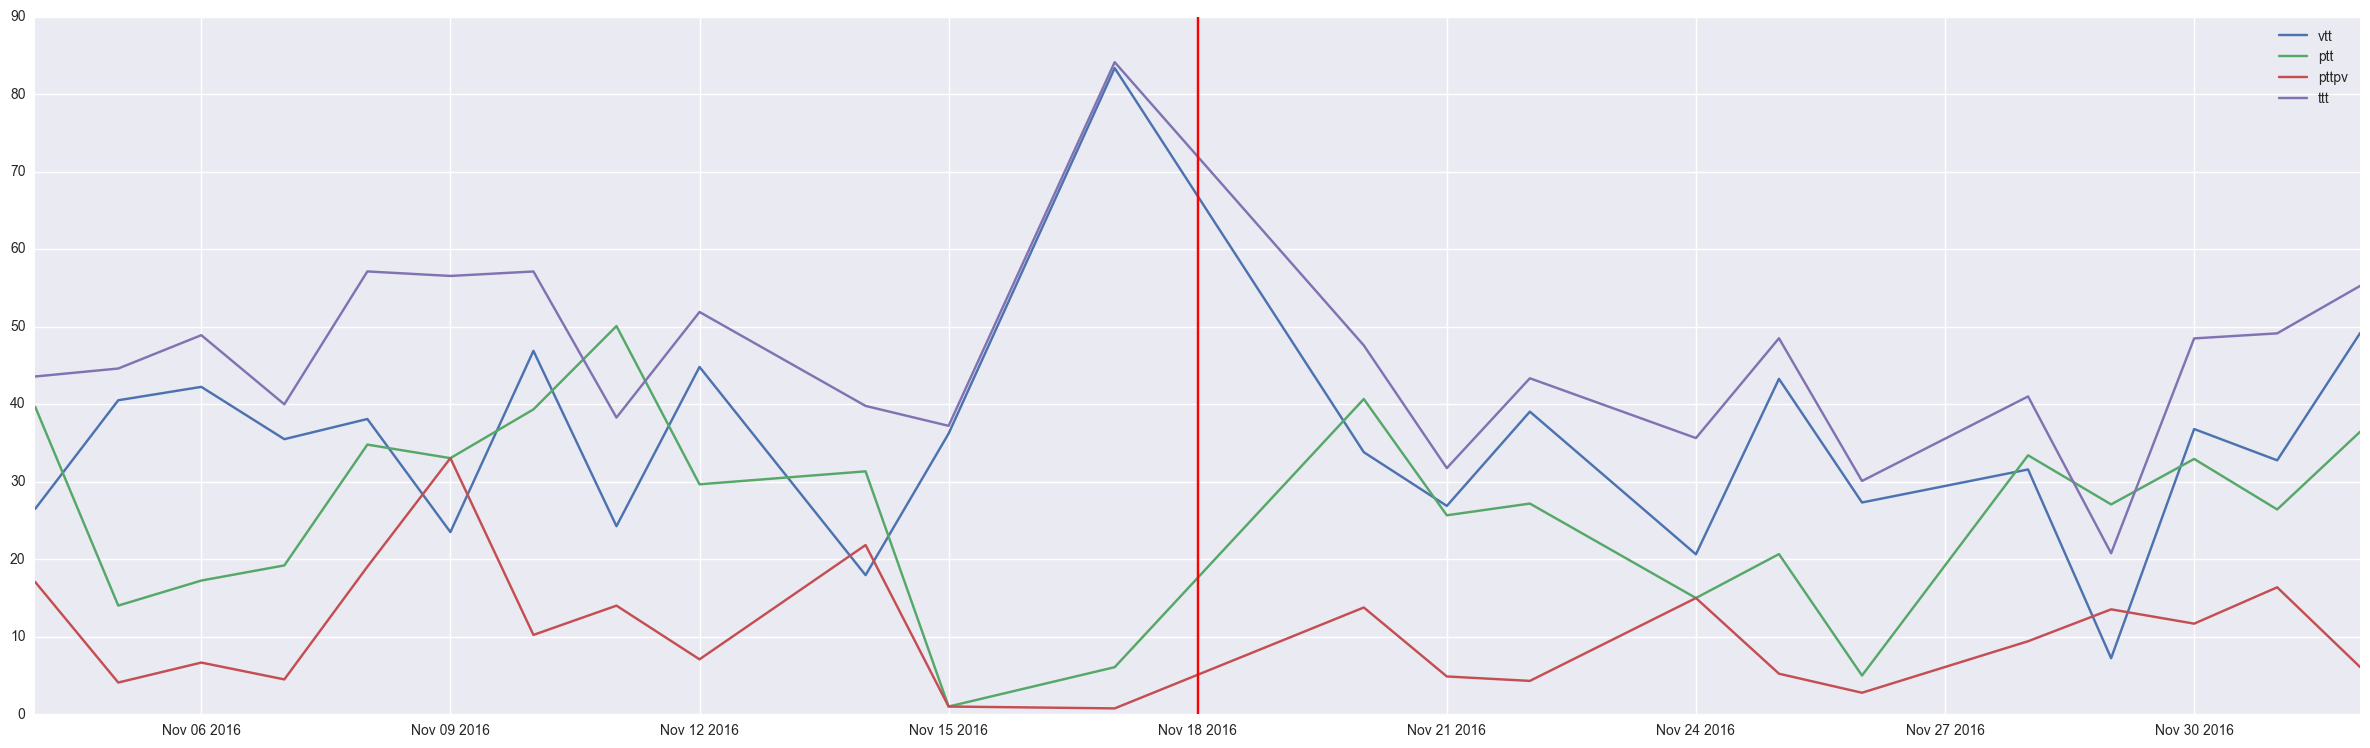

In [18]:
location_dfs['1-BAY']['daily'].plot(figsize=(30, 9))
plt.axvline(logic_change_date, c='r')

### Statistical Analysis

In [19]:
logic_change_date

datetime.date(2016, 11, 18)

In [20]:
for market in location_dfs:
    location_dfs[market]['before'] = {}
    location_dfs[market]['after'] = {}

In [21]:
# calculate before/after data split

for market in location_dfs:
    before_data = location_dfs[market]['data'][location_dfs[market]['data'].index < logic_change_date]
    before_data.drop('market', axis=1, inplace=True)
    location_dfs[market]['before']['data'] = before_data
    
    # after
    after_data = location_dfs[market]['data'][location_dfs[market]['data'].index > logic_change_date]
    after_data.drop('market', axis=1, inplace=True)
    location_dfs[market]['after']['data'] = after_data

/Users/lucasramadan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/lucasramadan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [22]:
for market in location_dfs:
    for ts in ['before', 'after']:
        for metric in location_dfs[market][ts]['data']:
            d = reduce(lambda x,y: x+y, location_dfs[market][ts]['data'][metric].values)
            location_dfs[market][ts][metric] = d

In [23]:
location_dfs['1-BAY'].keys()

['after', 'data', 'daily', 'before']

In [38]:
len(location_dfs['2-NY']['before']['ptt'])

28

(array([ 7.,  3.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  2.,  0.,  1.,
         1.,  3.,  1.,  1.,  2.,  0.,  0.,  2.,  0.,  0.,  0.,  1.,  1.,
         0.,  1.]),
 array([  5.        ,   6.99166667,   8.98333333,  10.975     ,
         12.96666667,  14.95833333,  16.95      ,  18.94166667,
         20.93333333,  22.925     ,  24.91666667,  26.90833333,
         28.9       ,  30.89166667,  32.88333333,  34.875     ,
         36.86666667,  38.85833333,  40.85      ,  42.84166667,
         44.83333333,  46.825     ,  48.81666667,  50.80833333,
         52.8       ,  54.79166667,  56.78333333,  58.775     ,  60.76666667]),
 <a list of 28 Patch objects>)

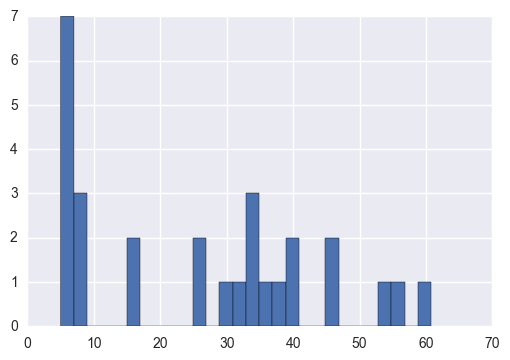

In [39]:
plt.hist(location_dfs['2-NY']['before']['ptt'], bins=28)

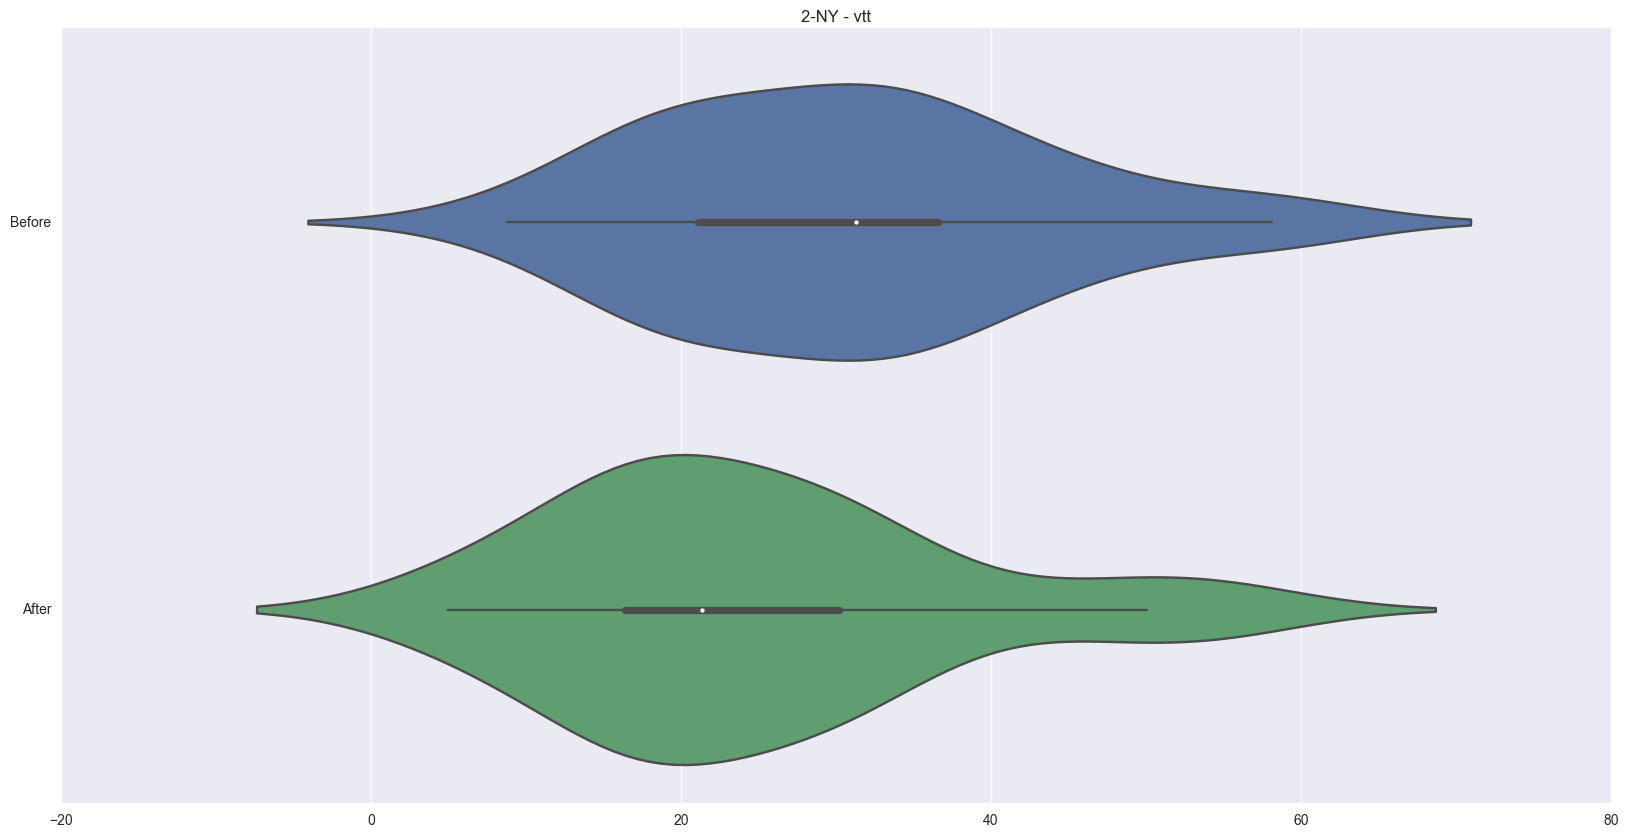

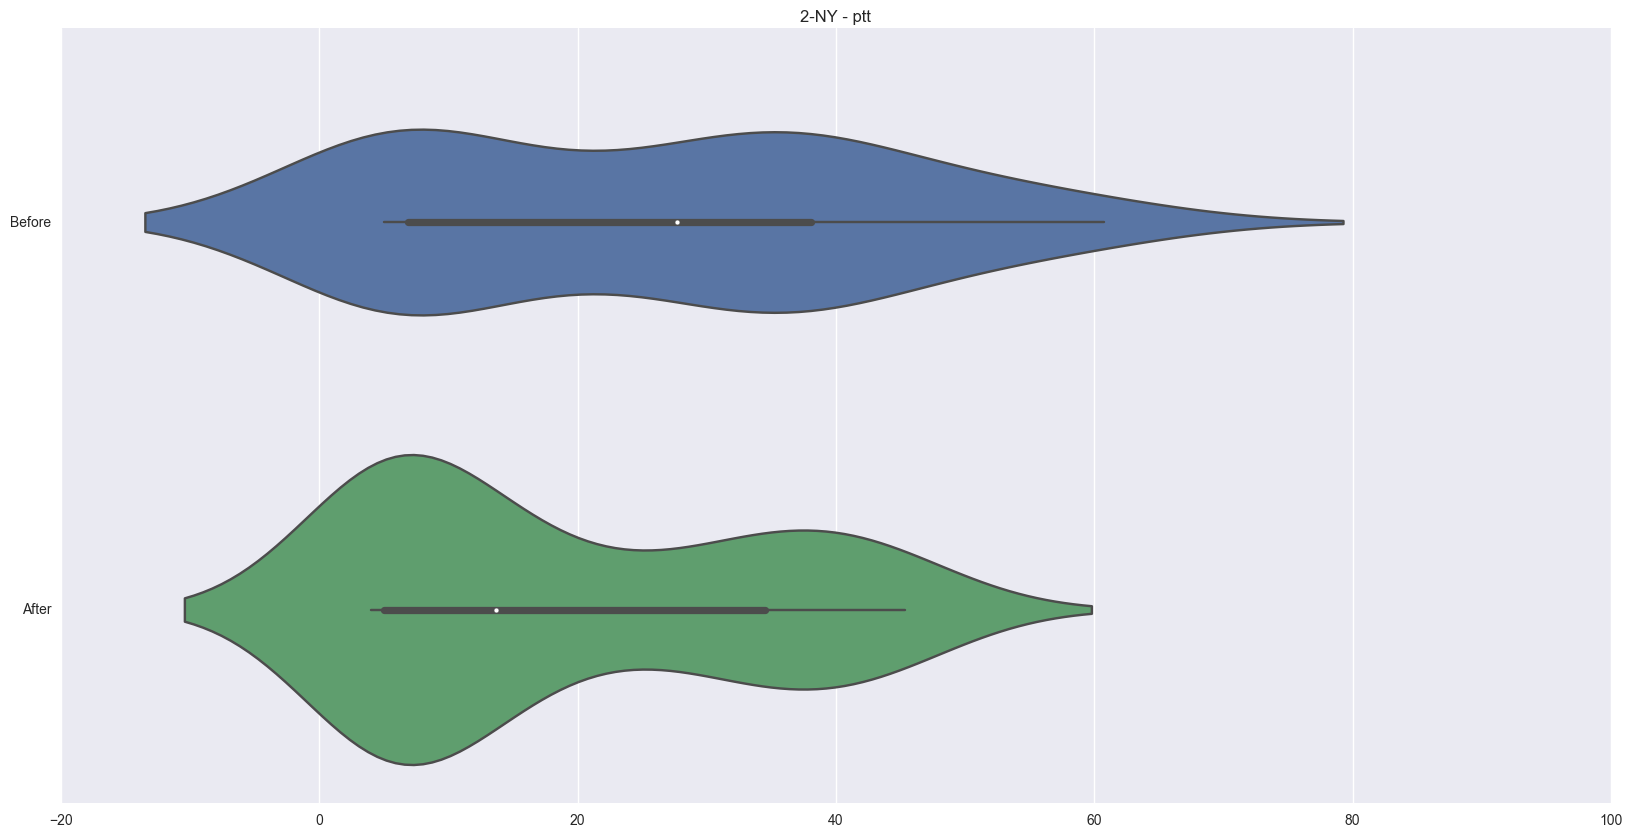

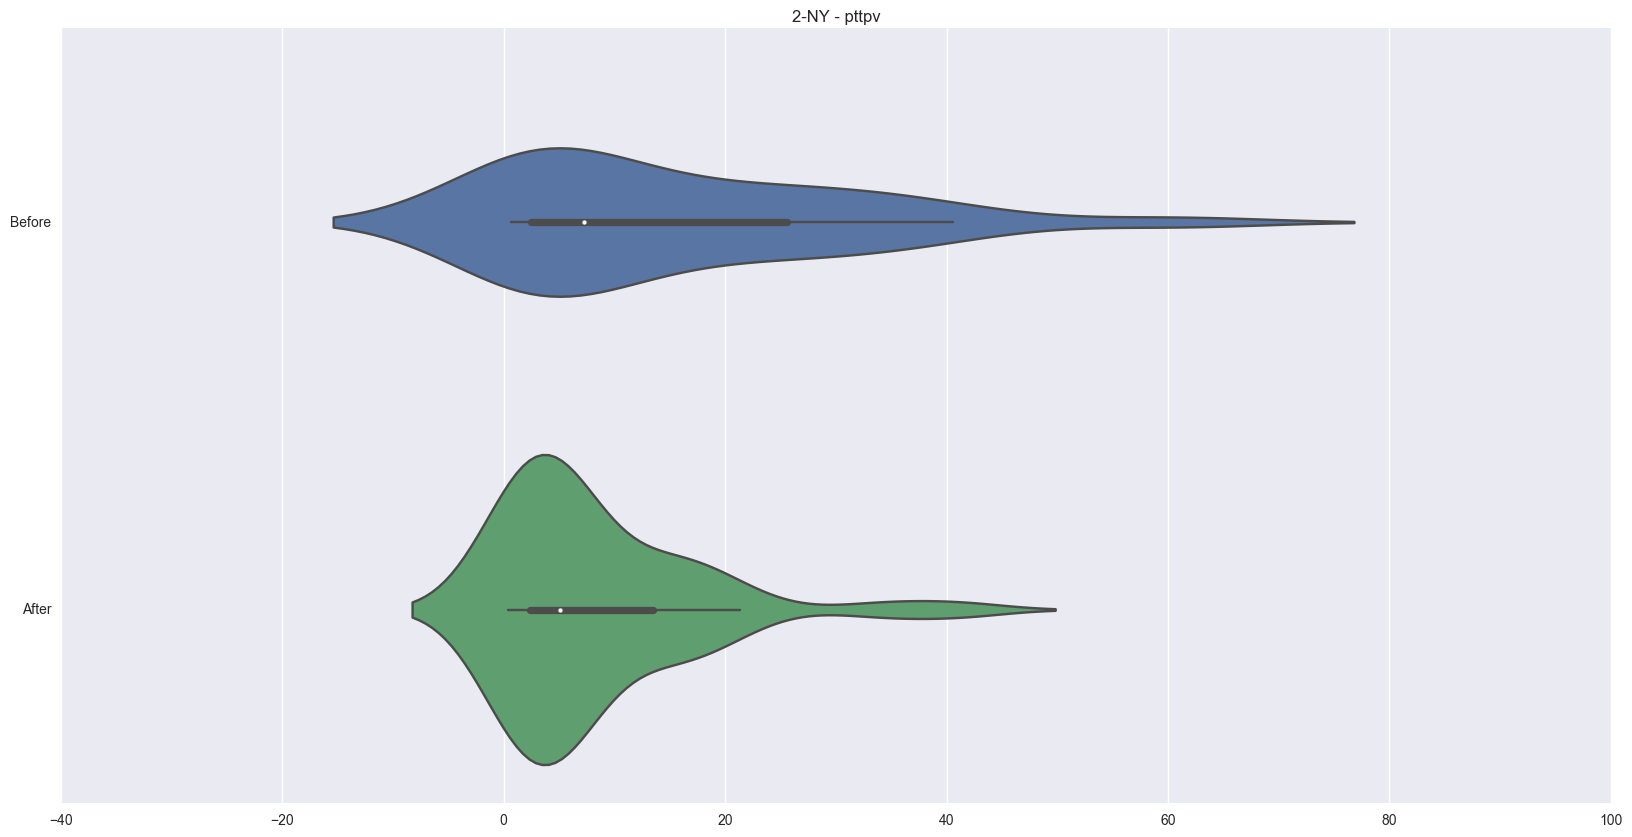

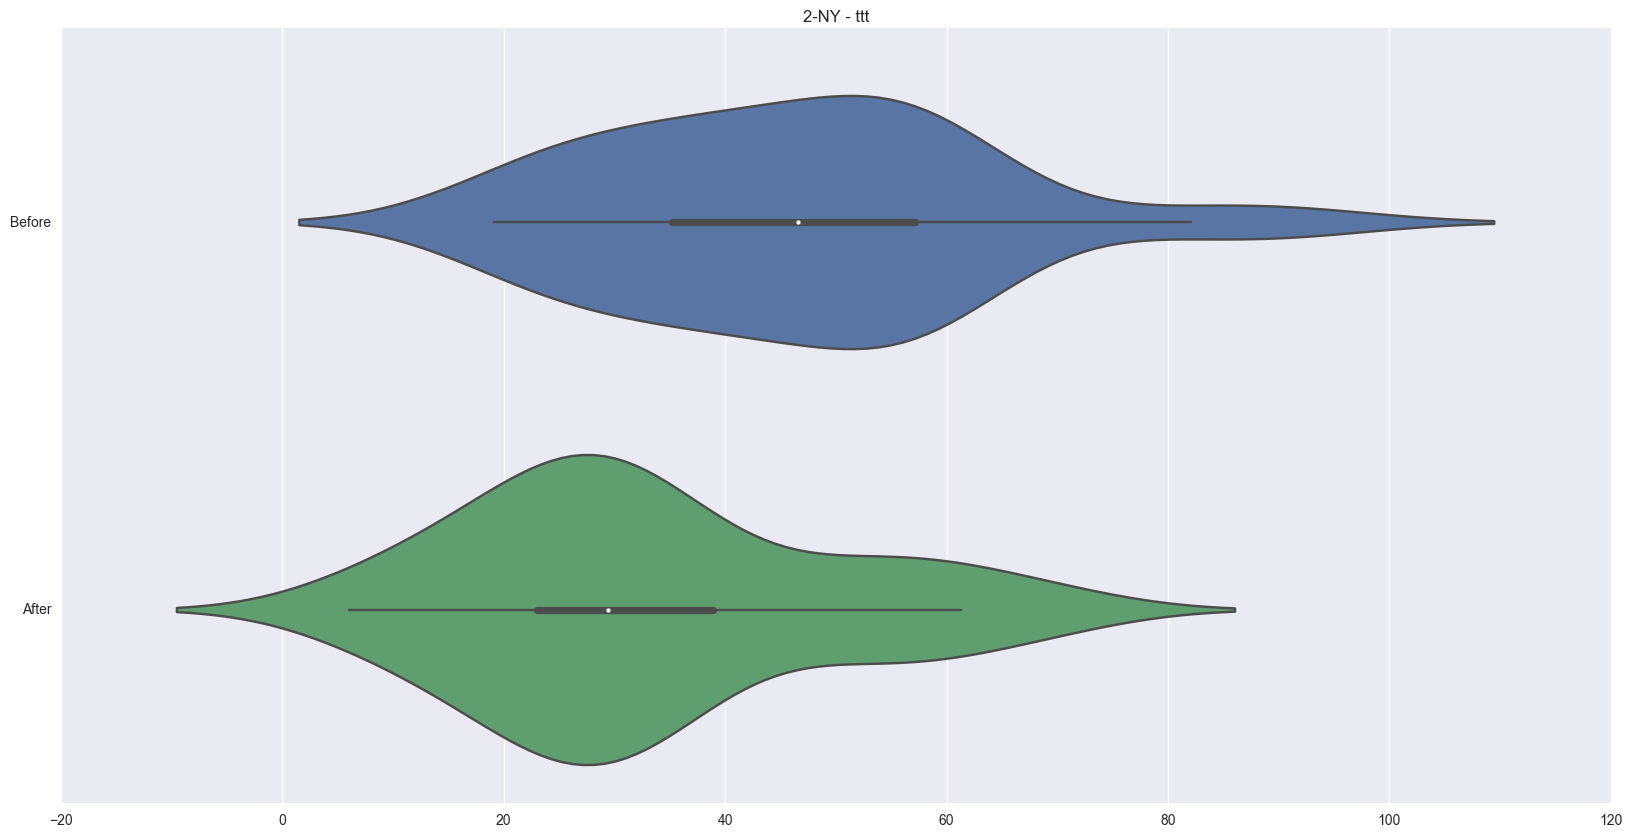

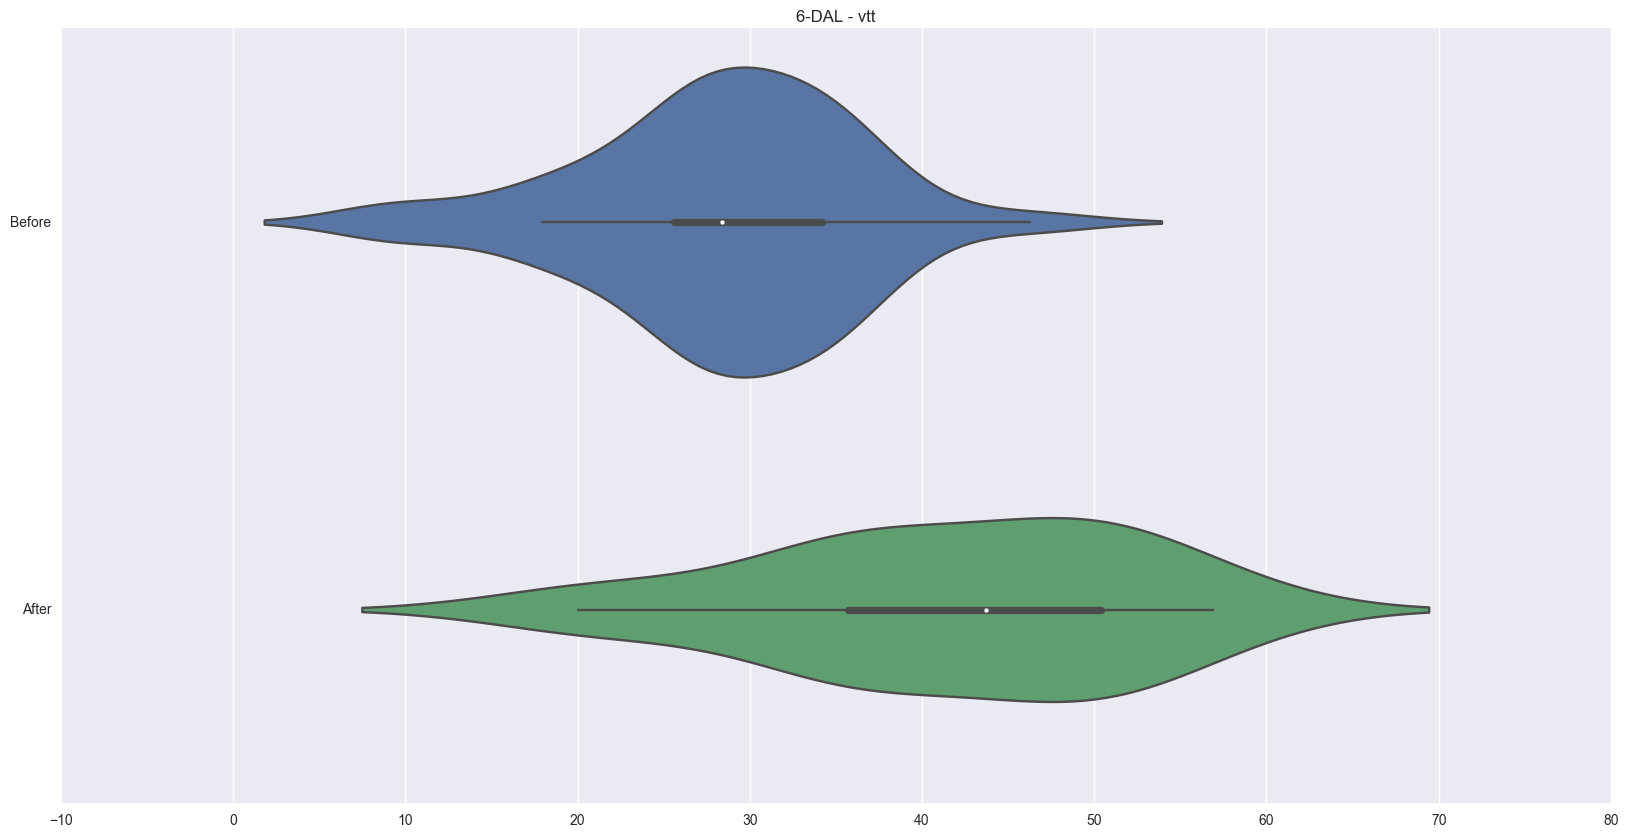

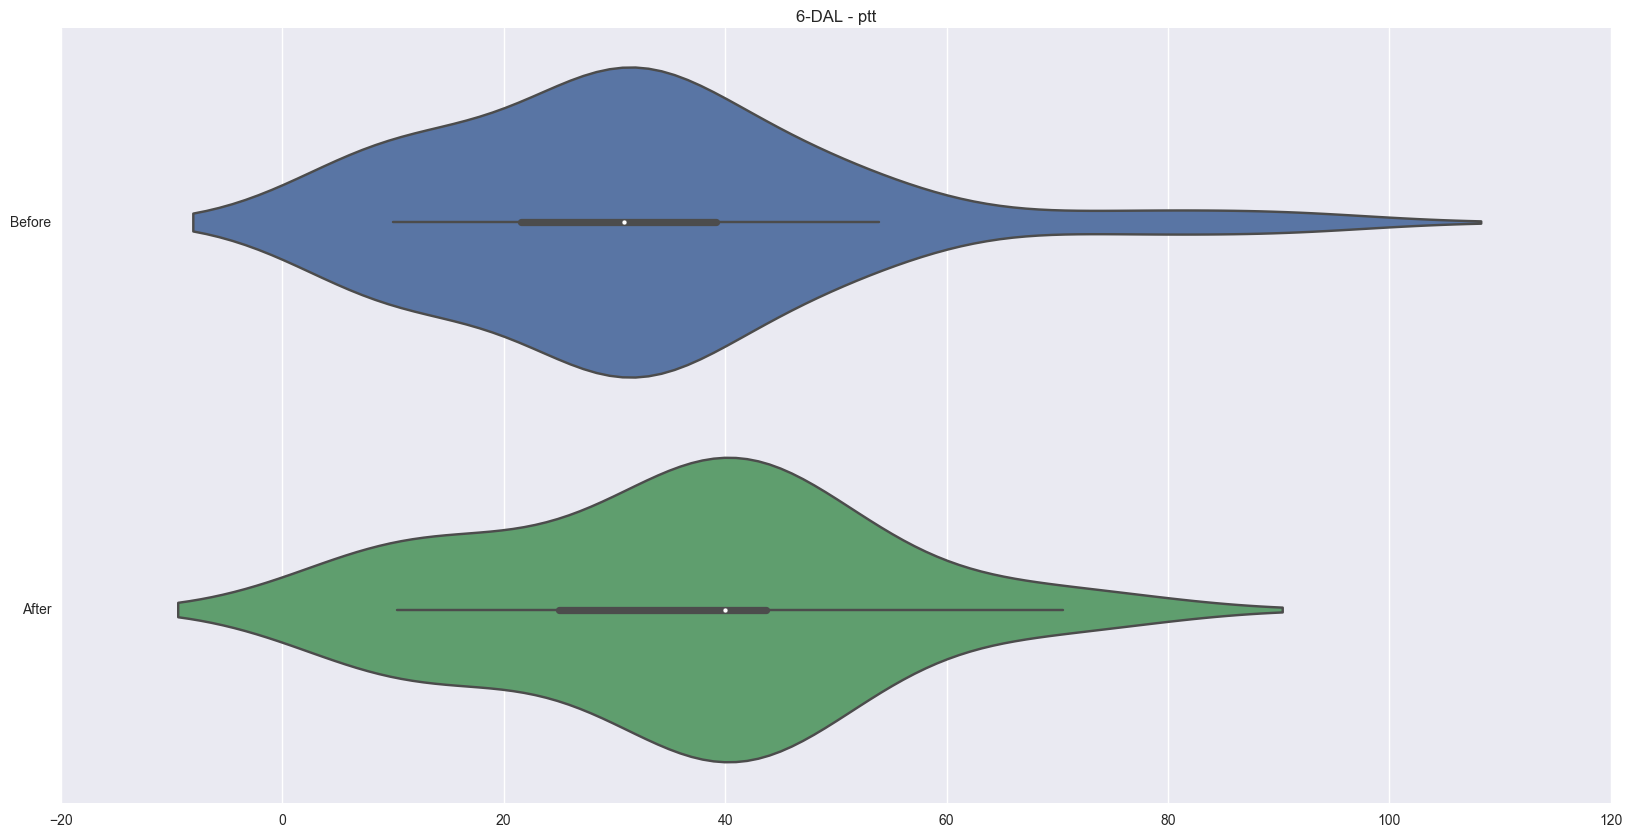

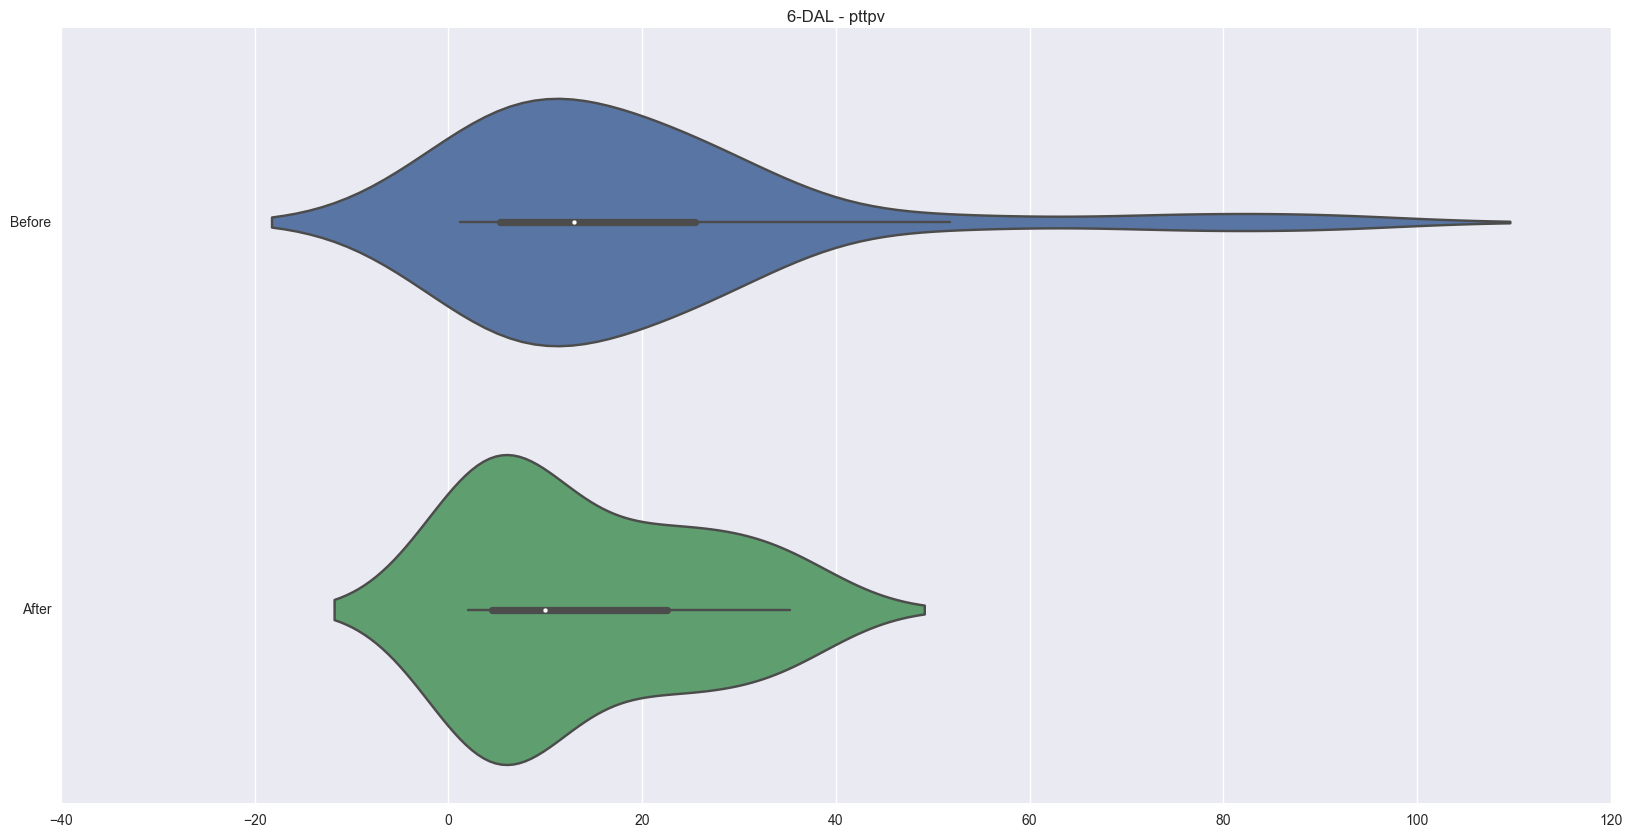

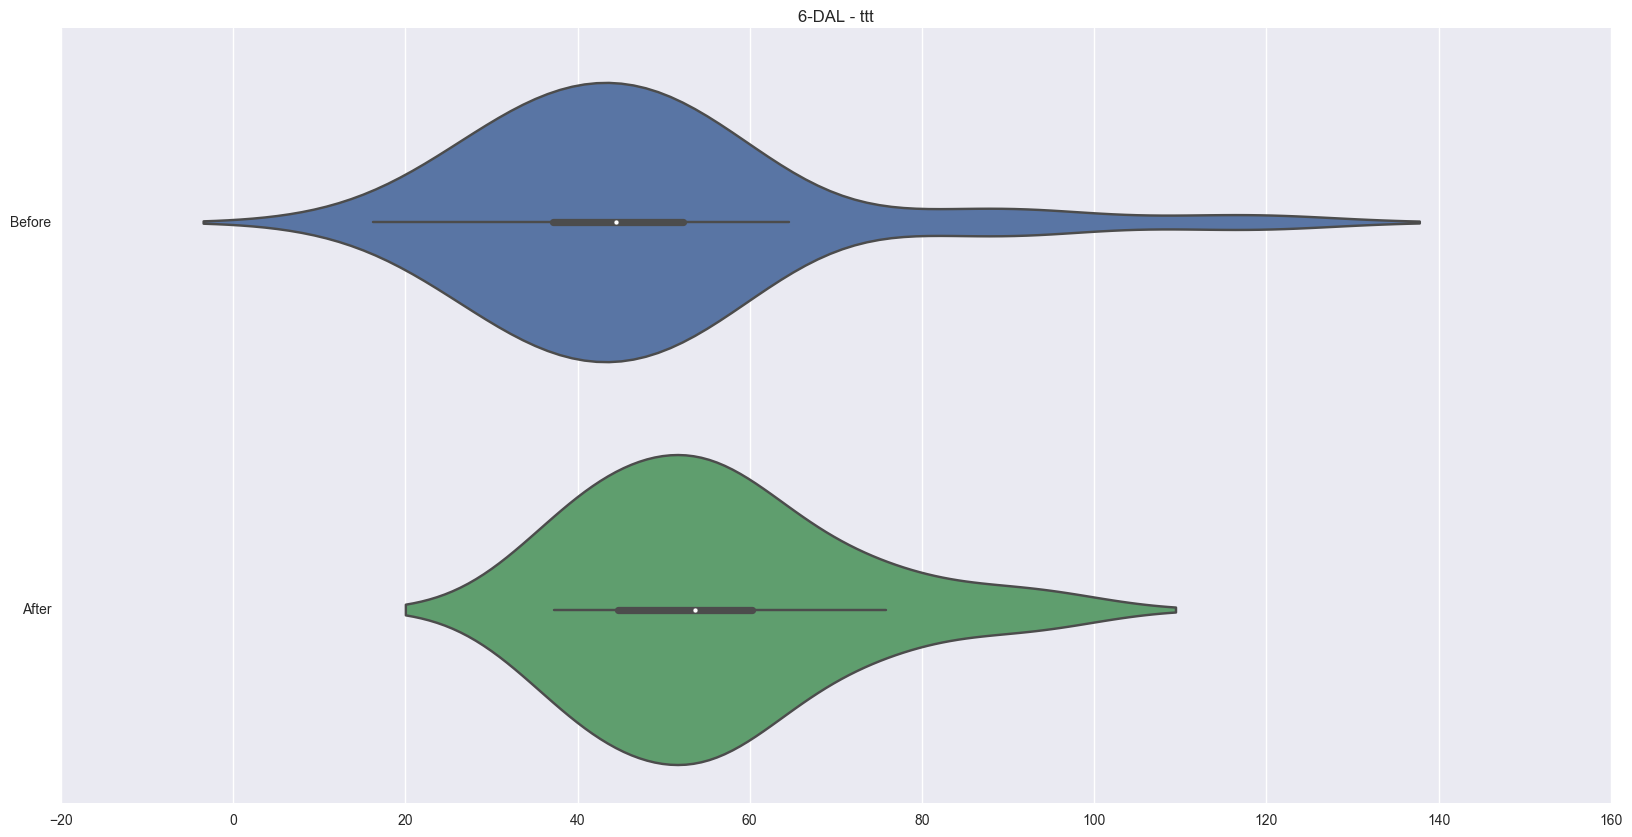

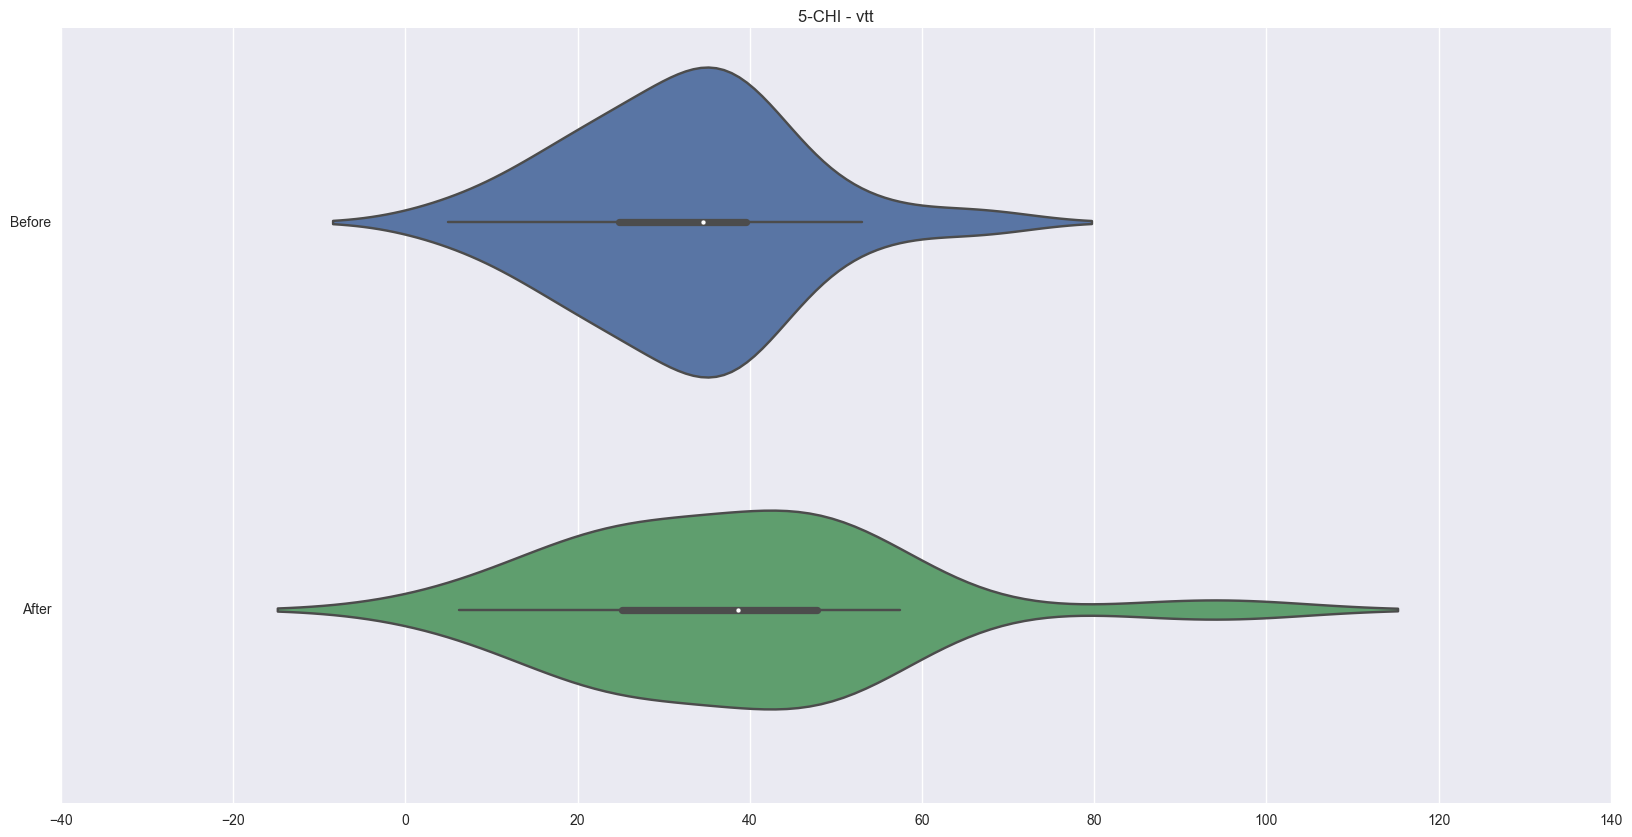

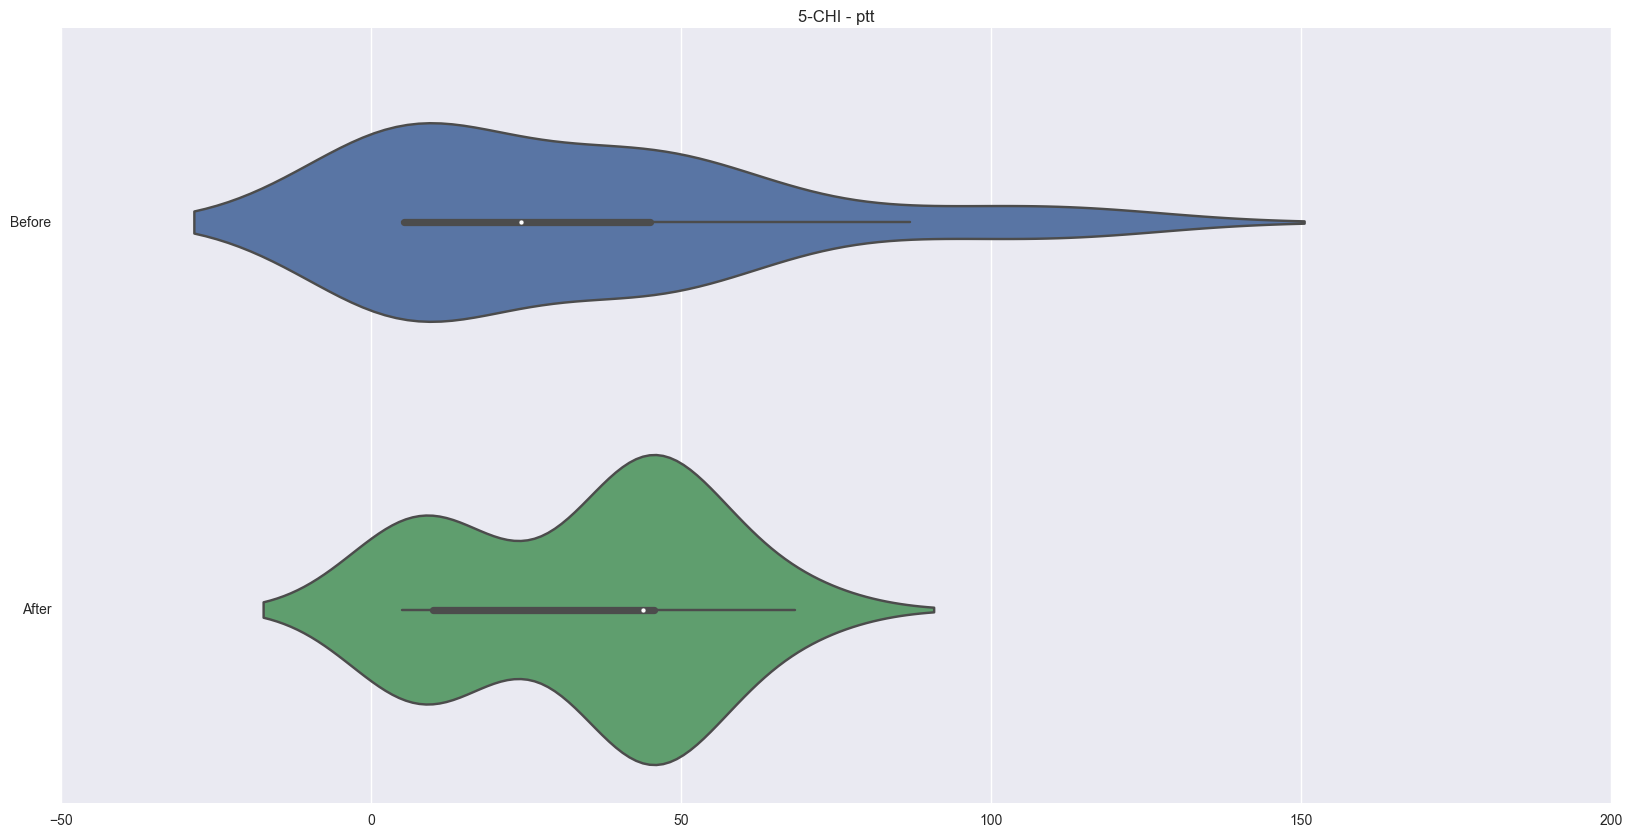

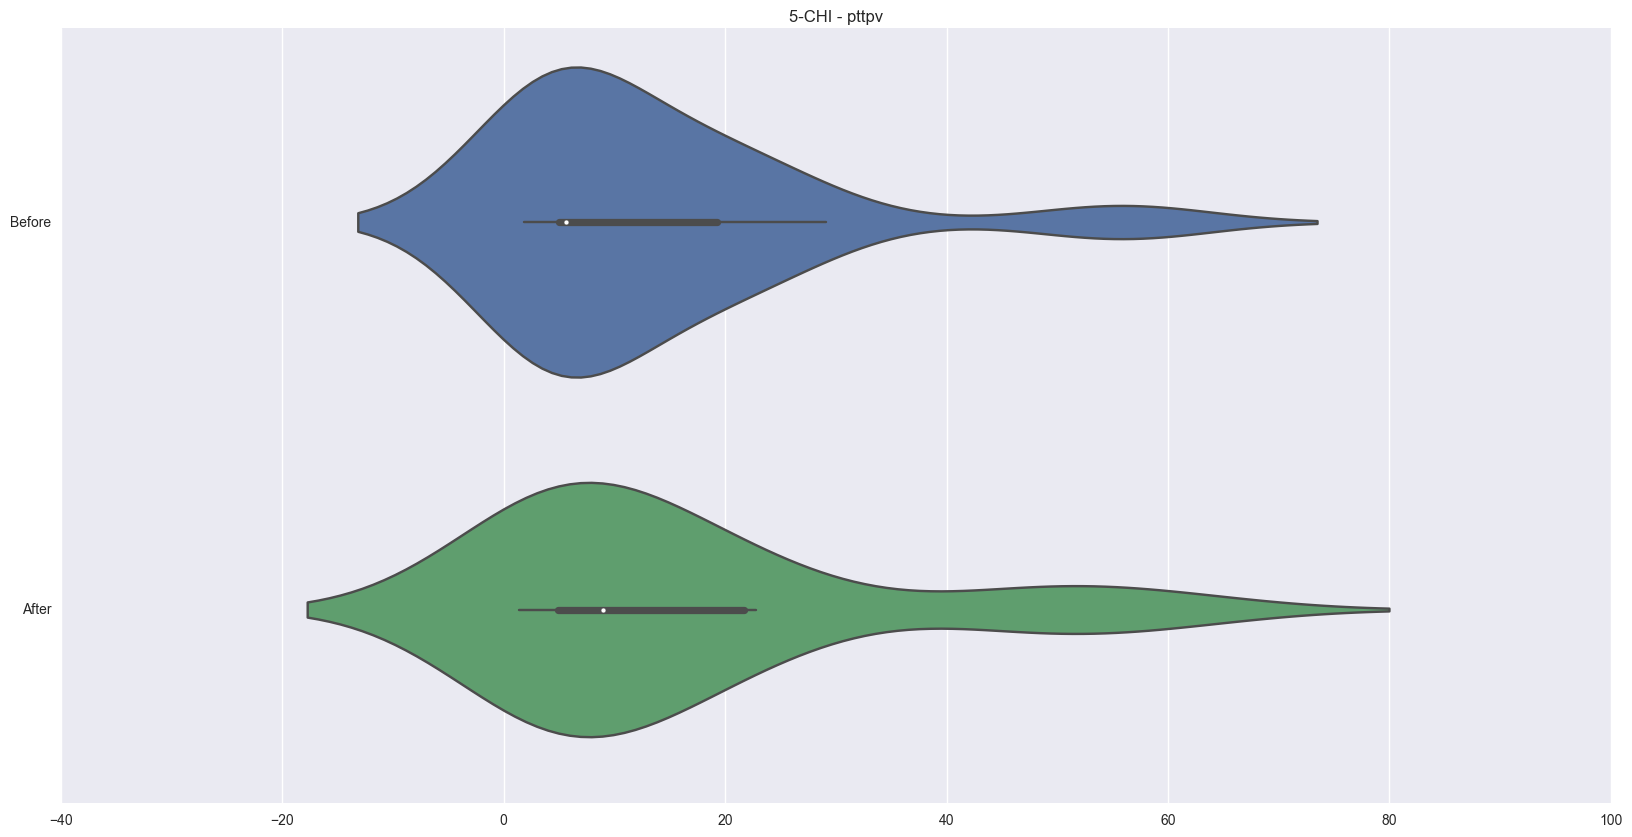

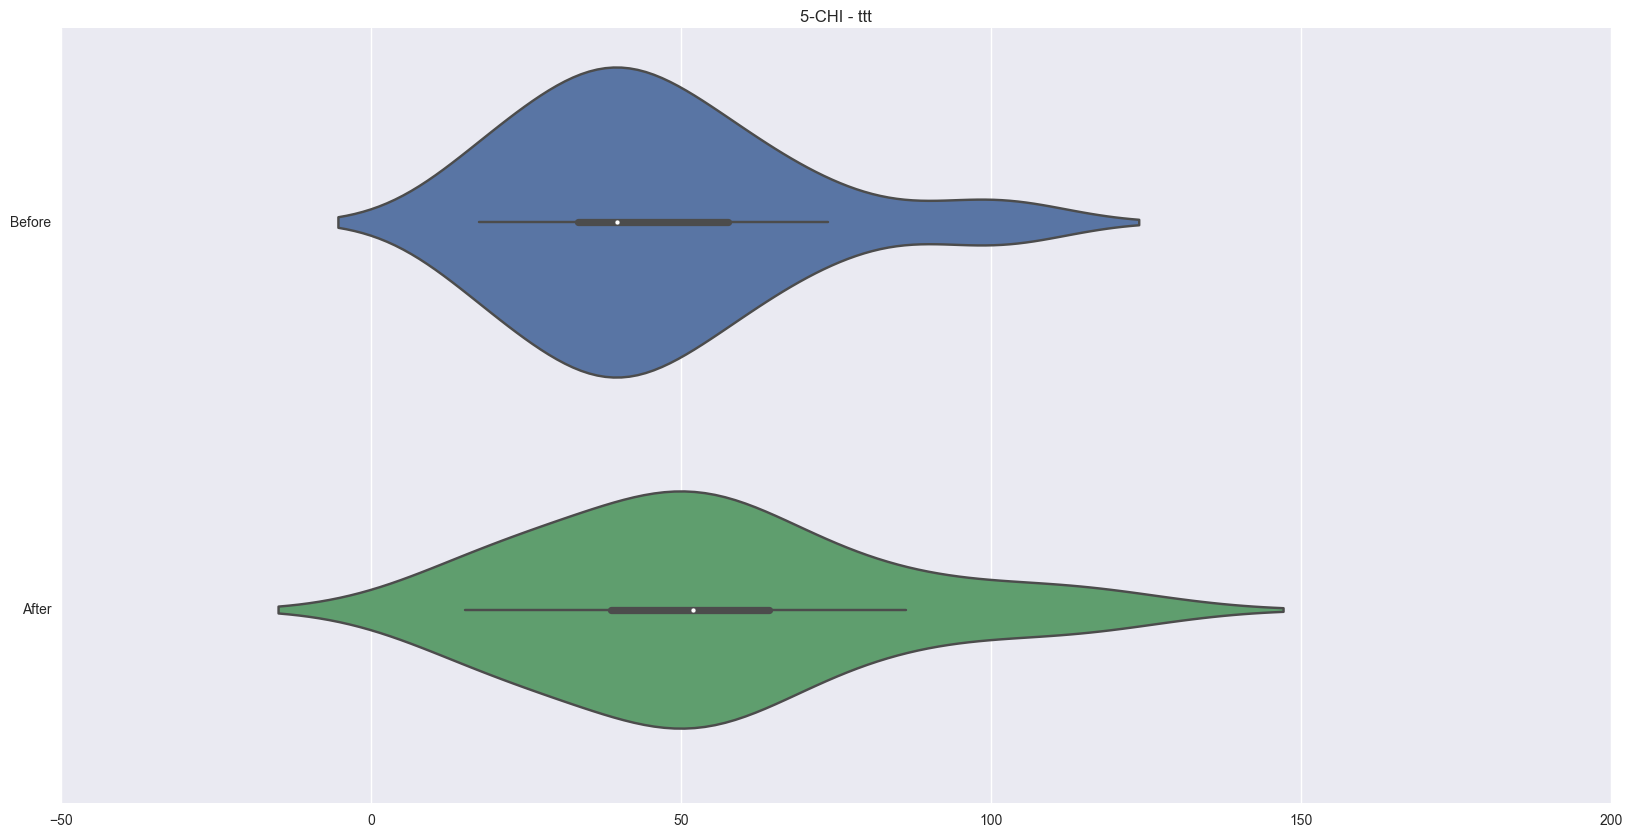

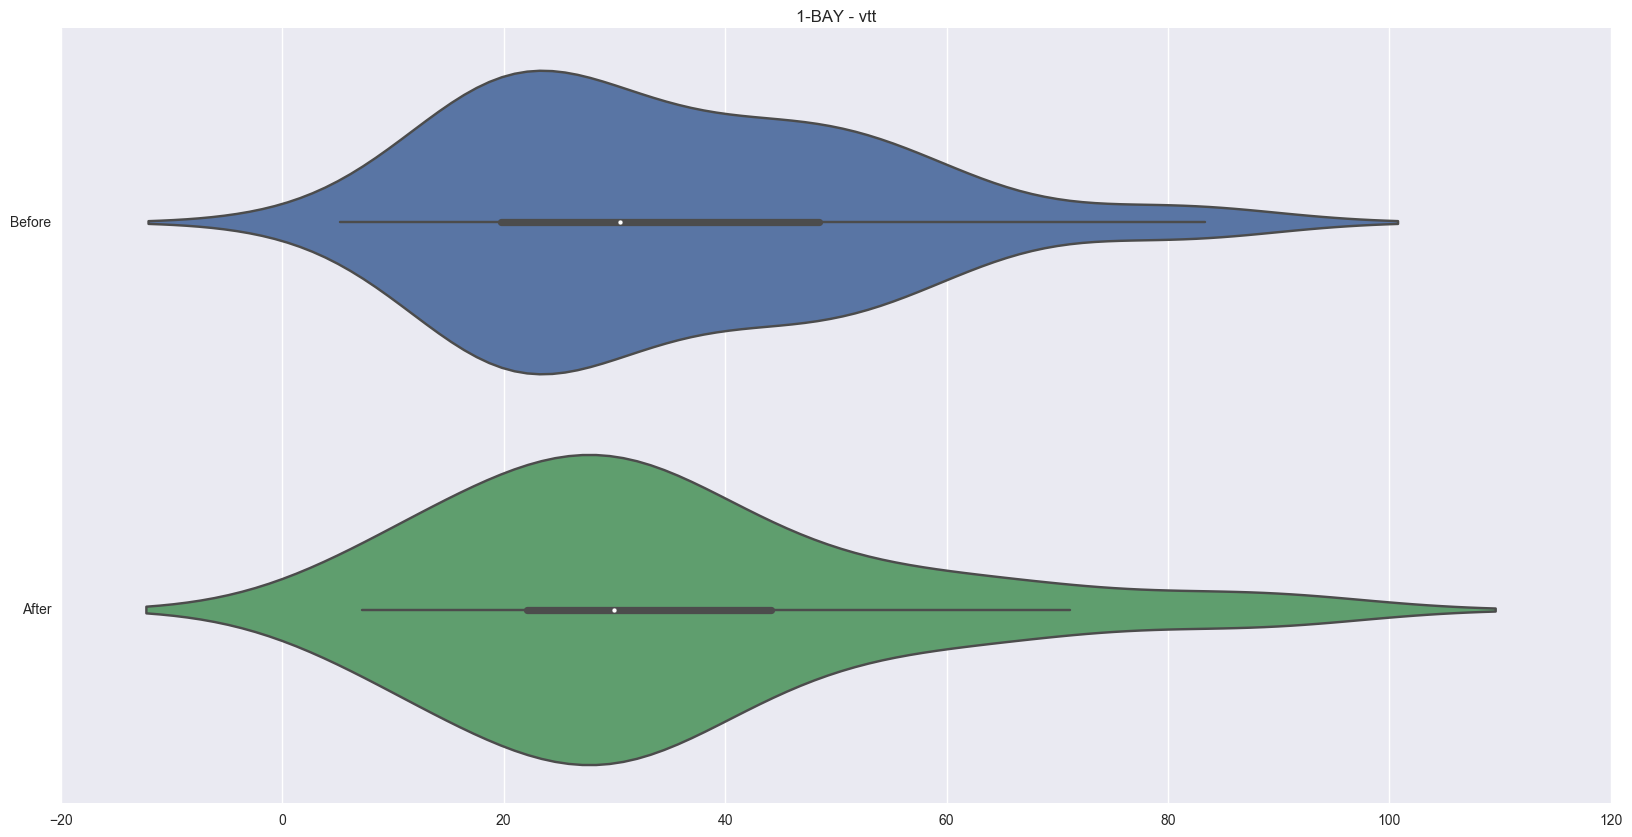

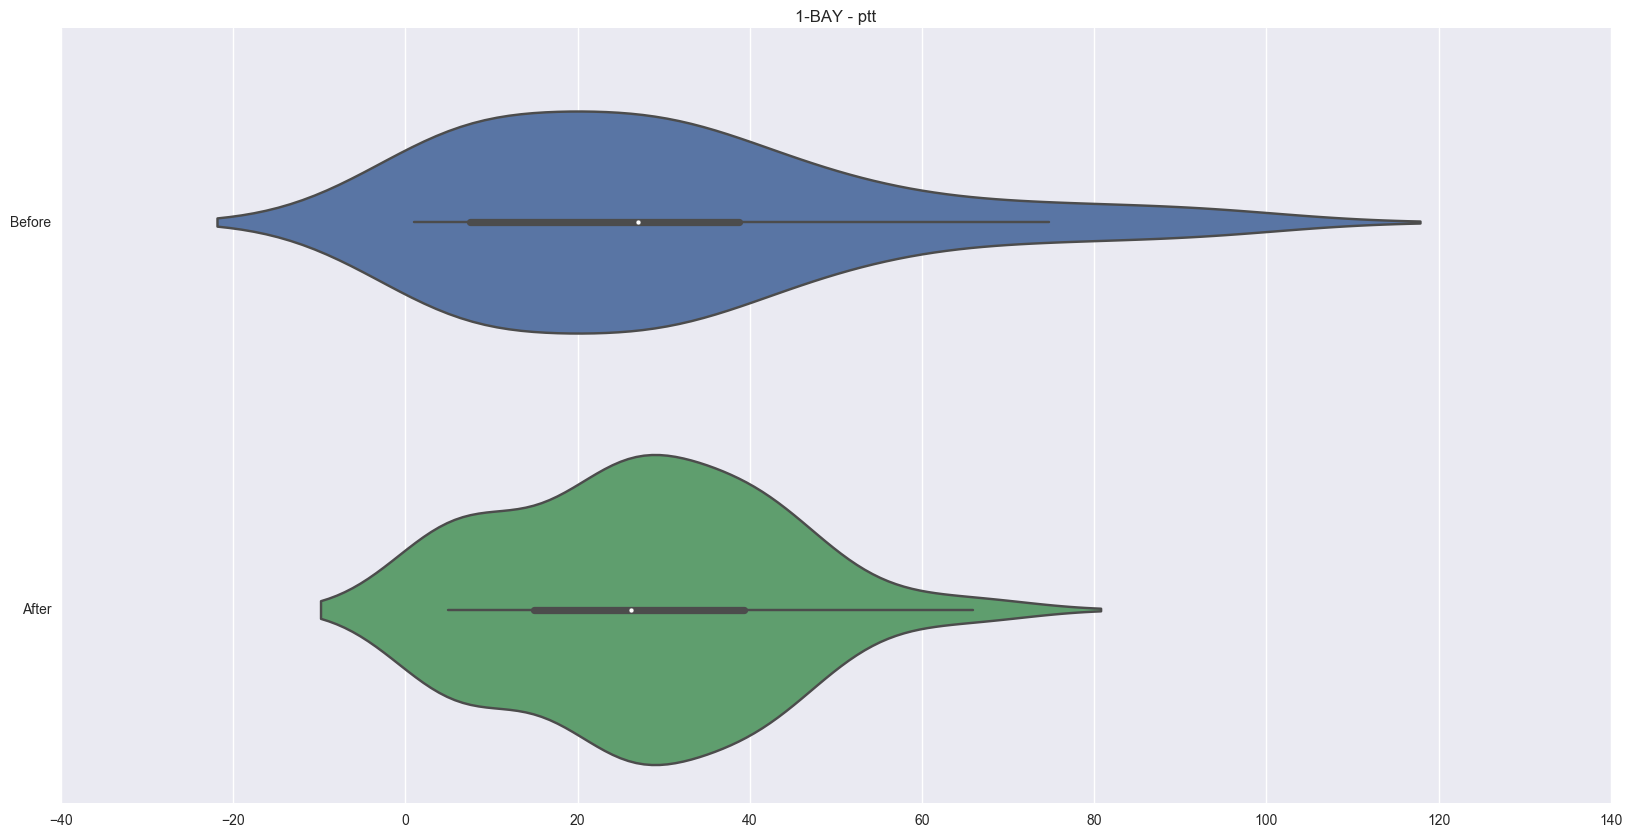

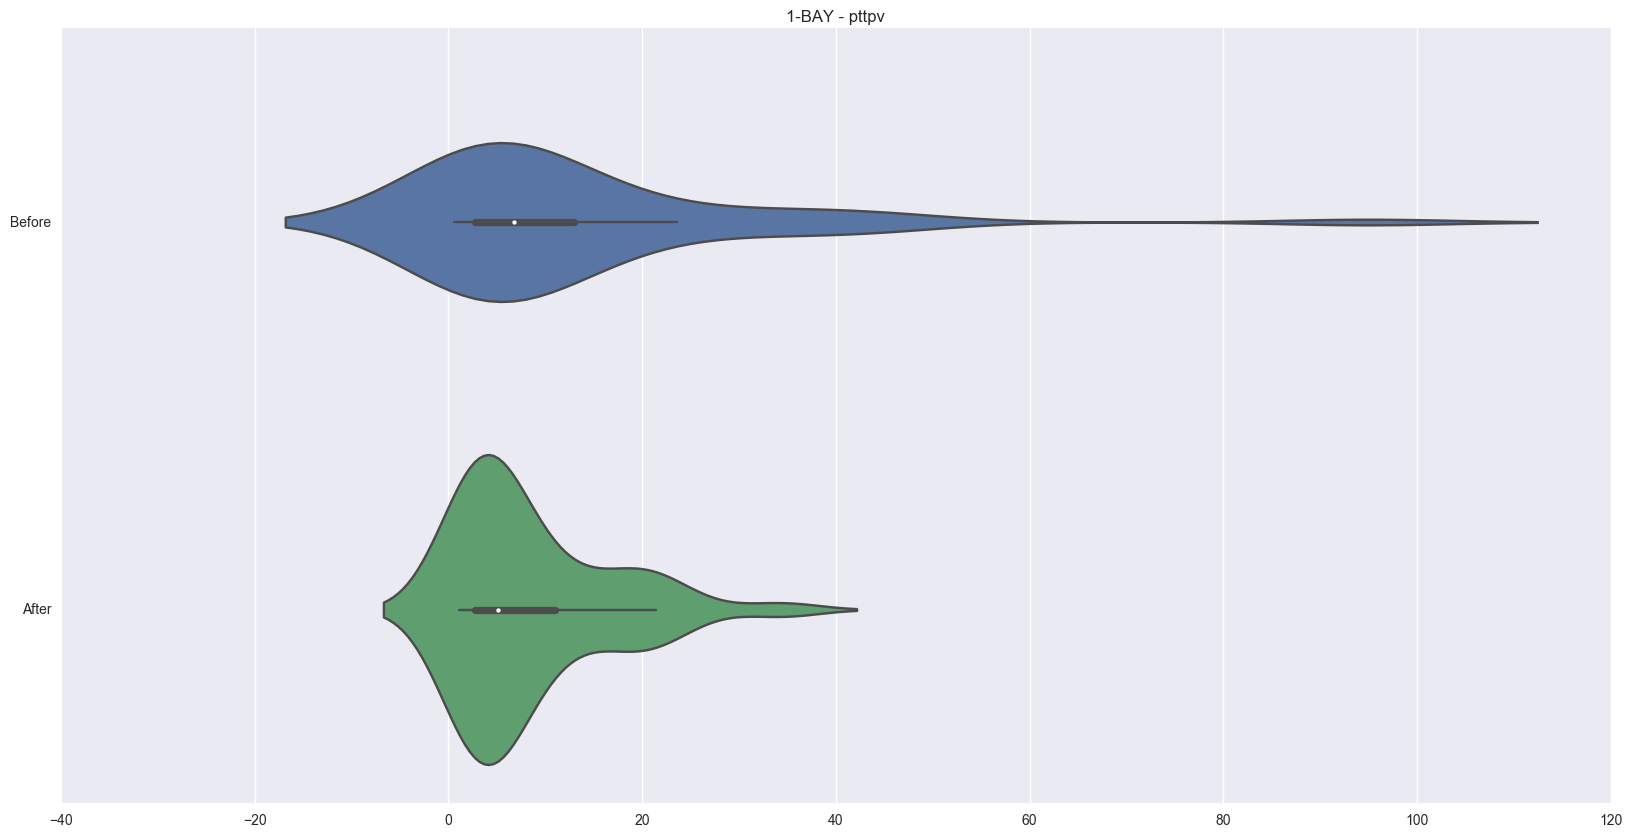

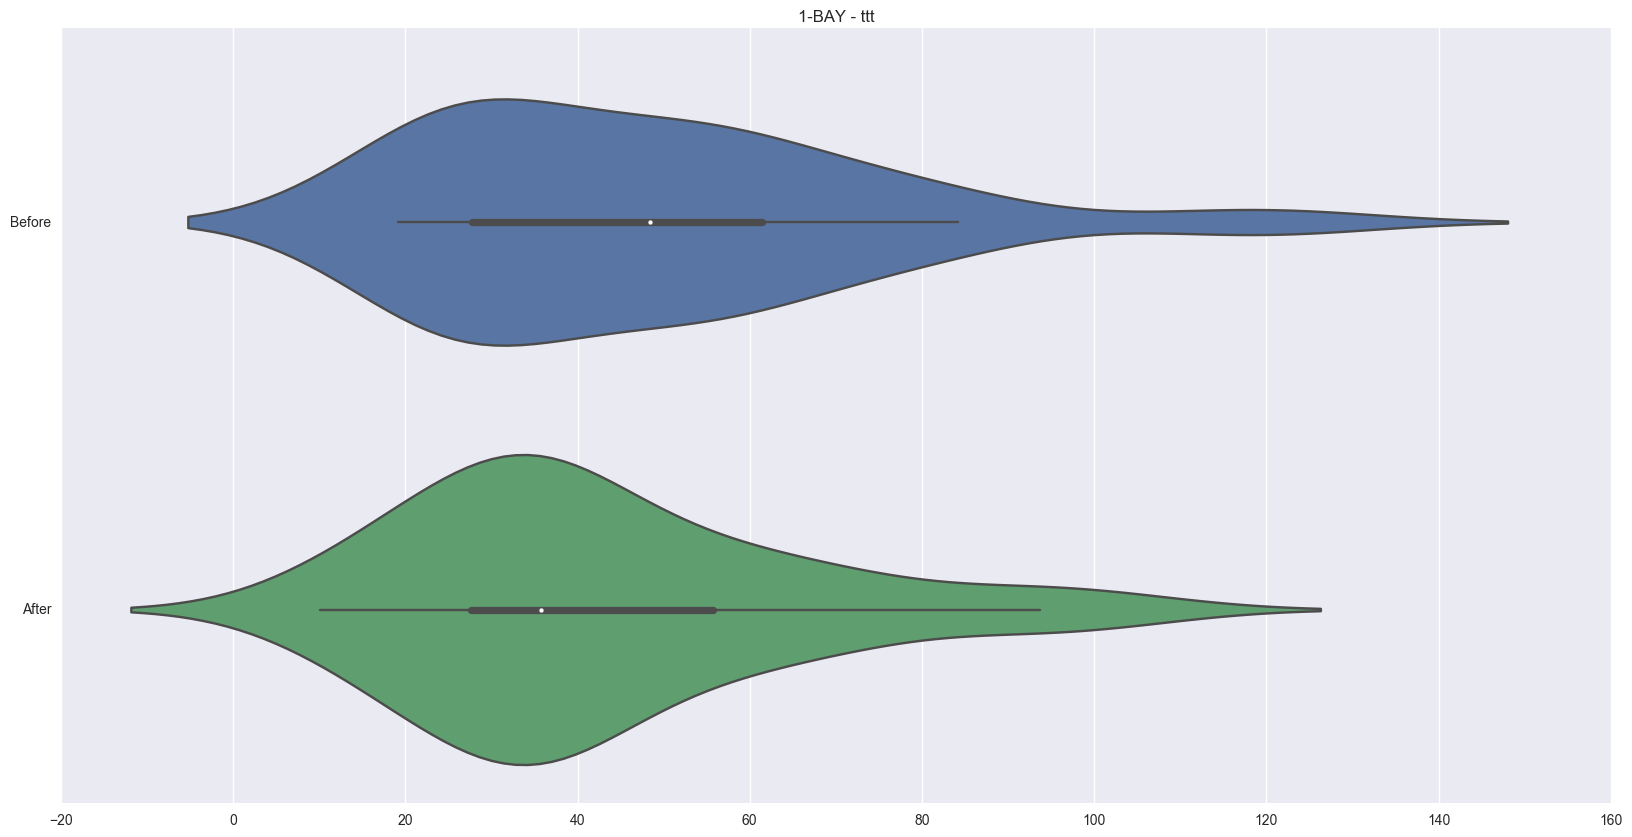

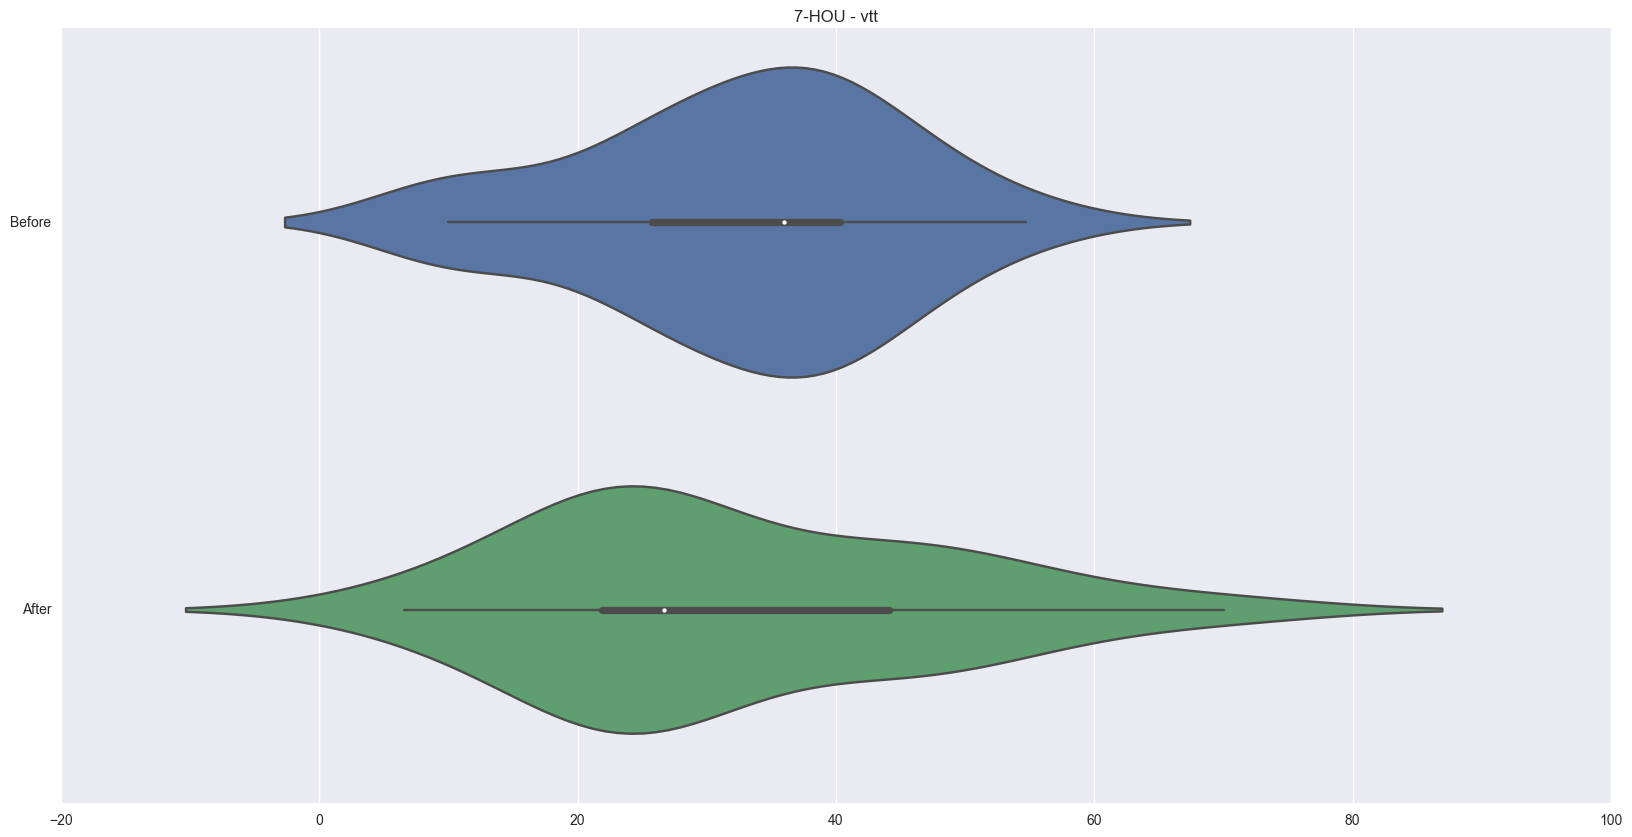

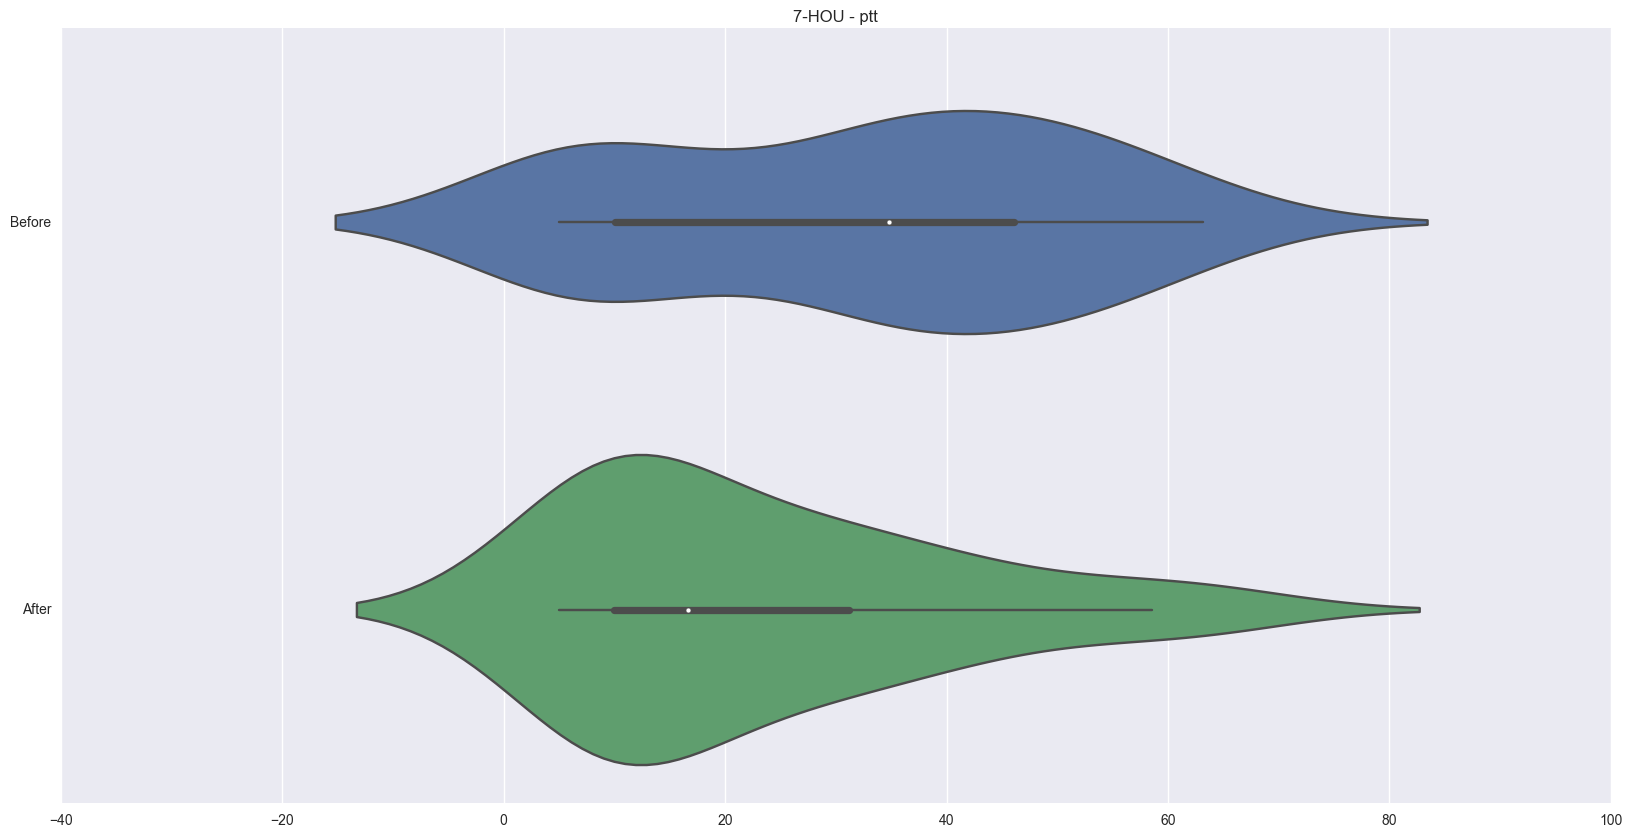

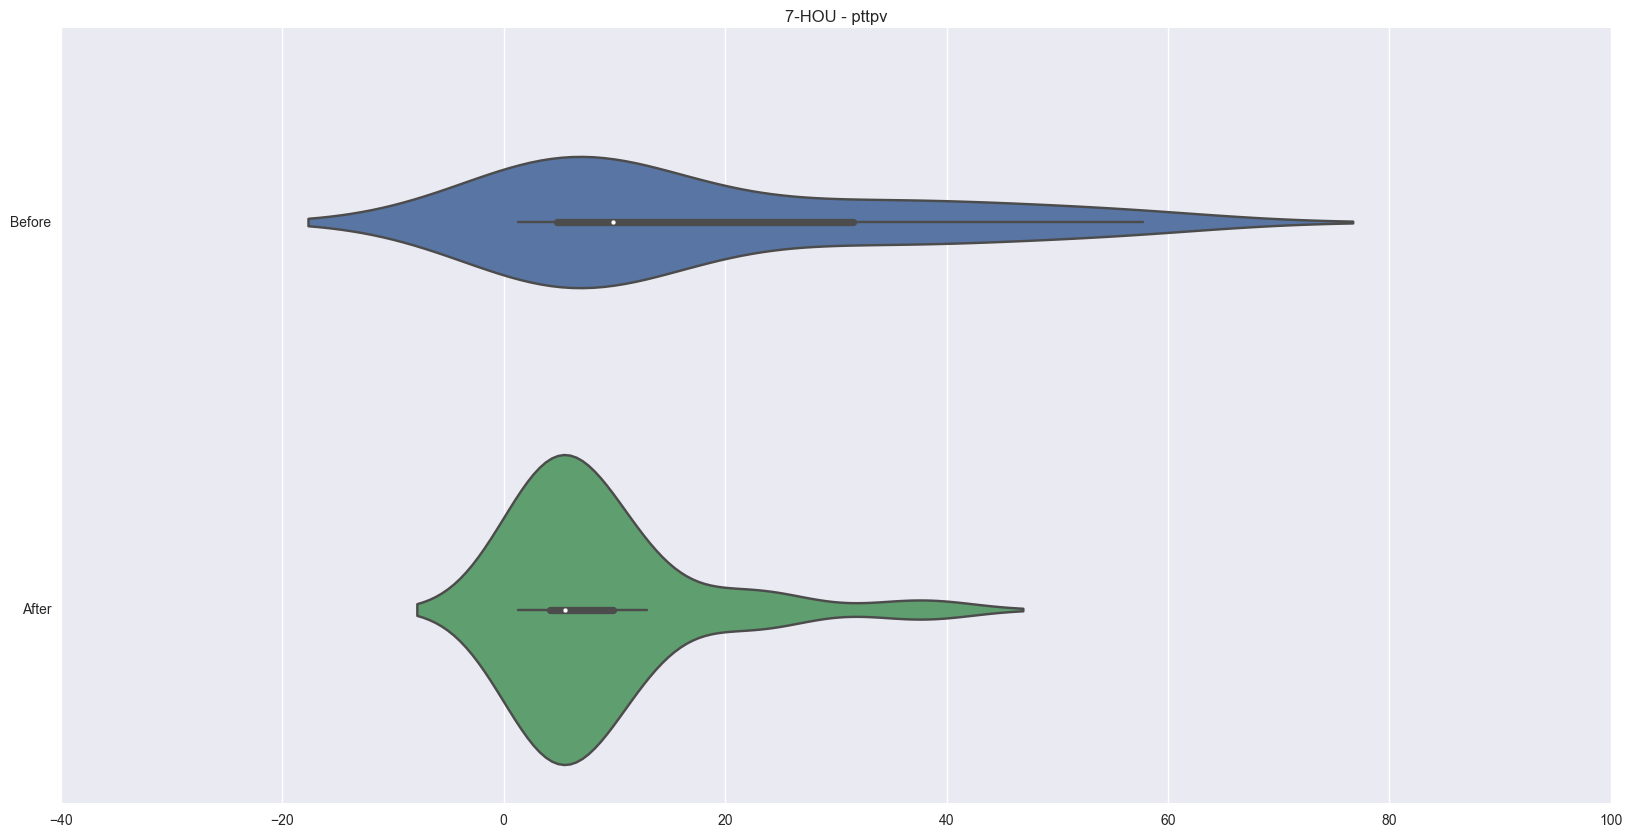

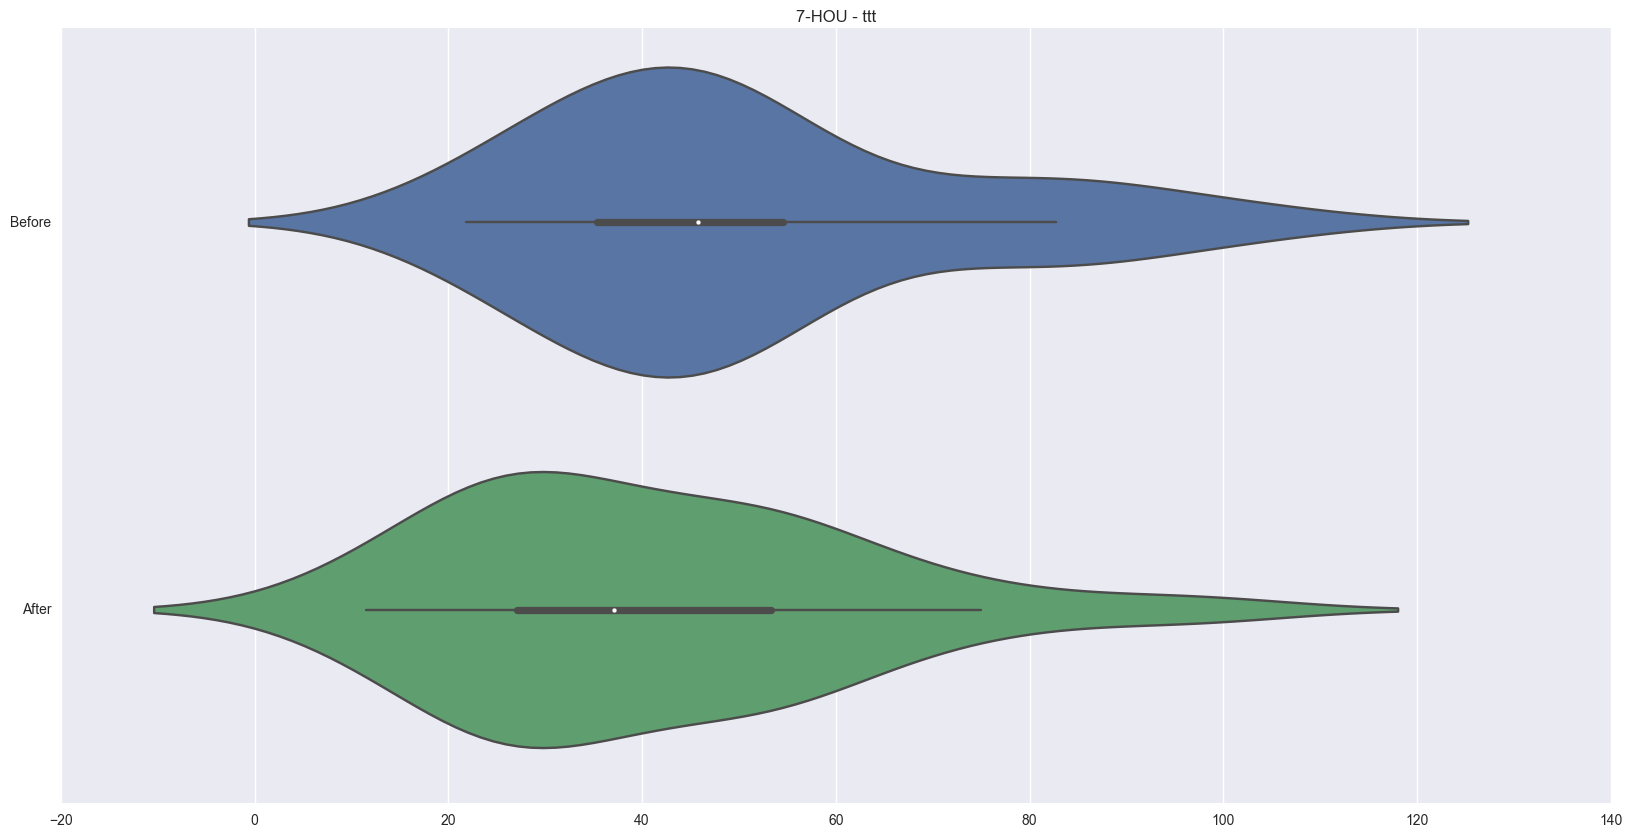

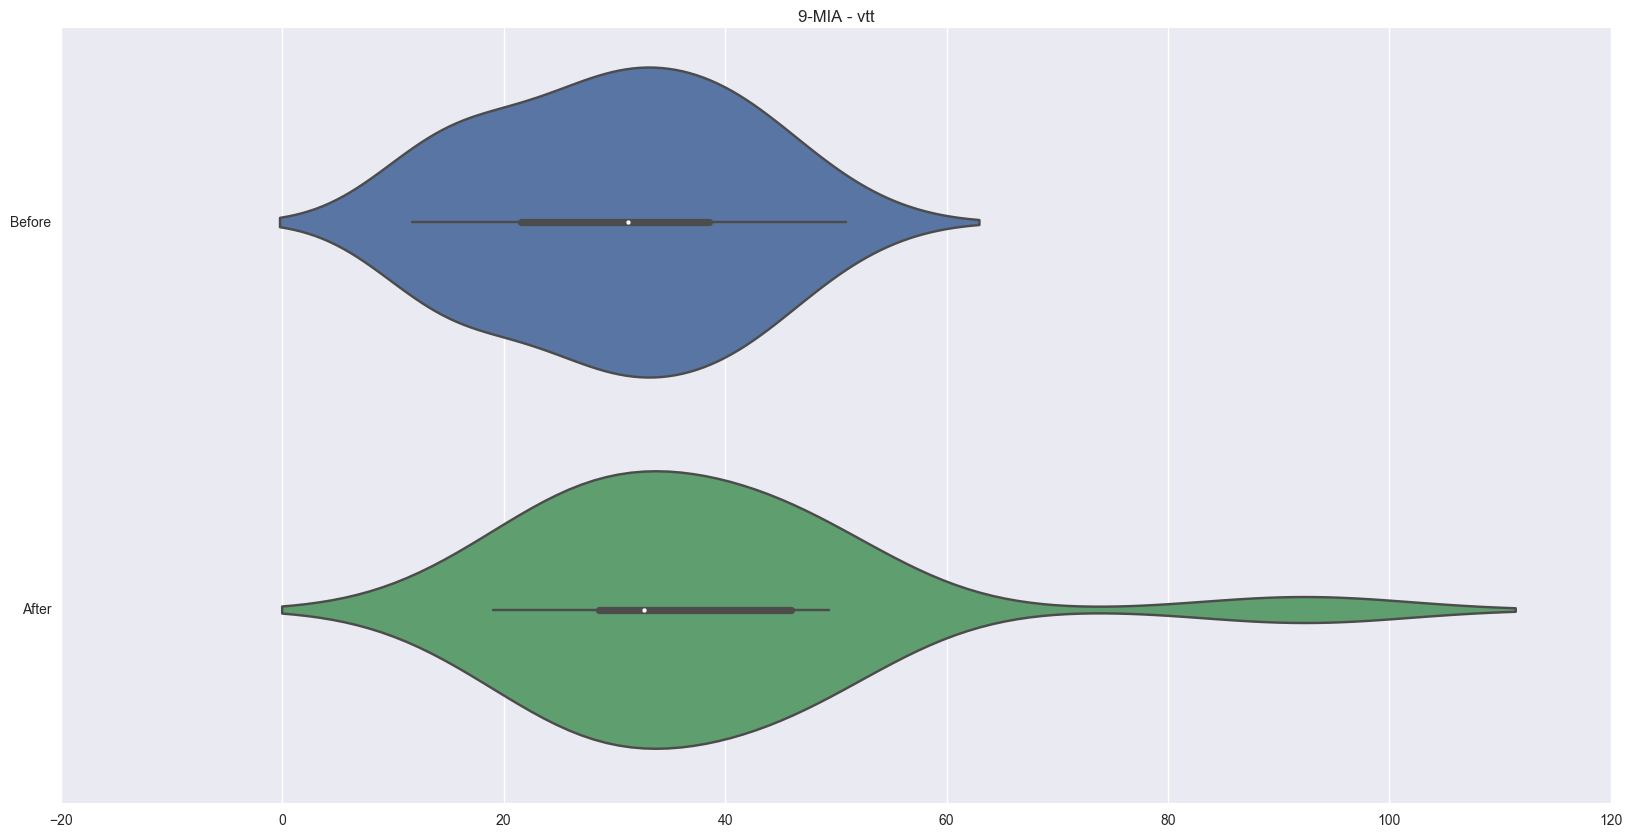

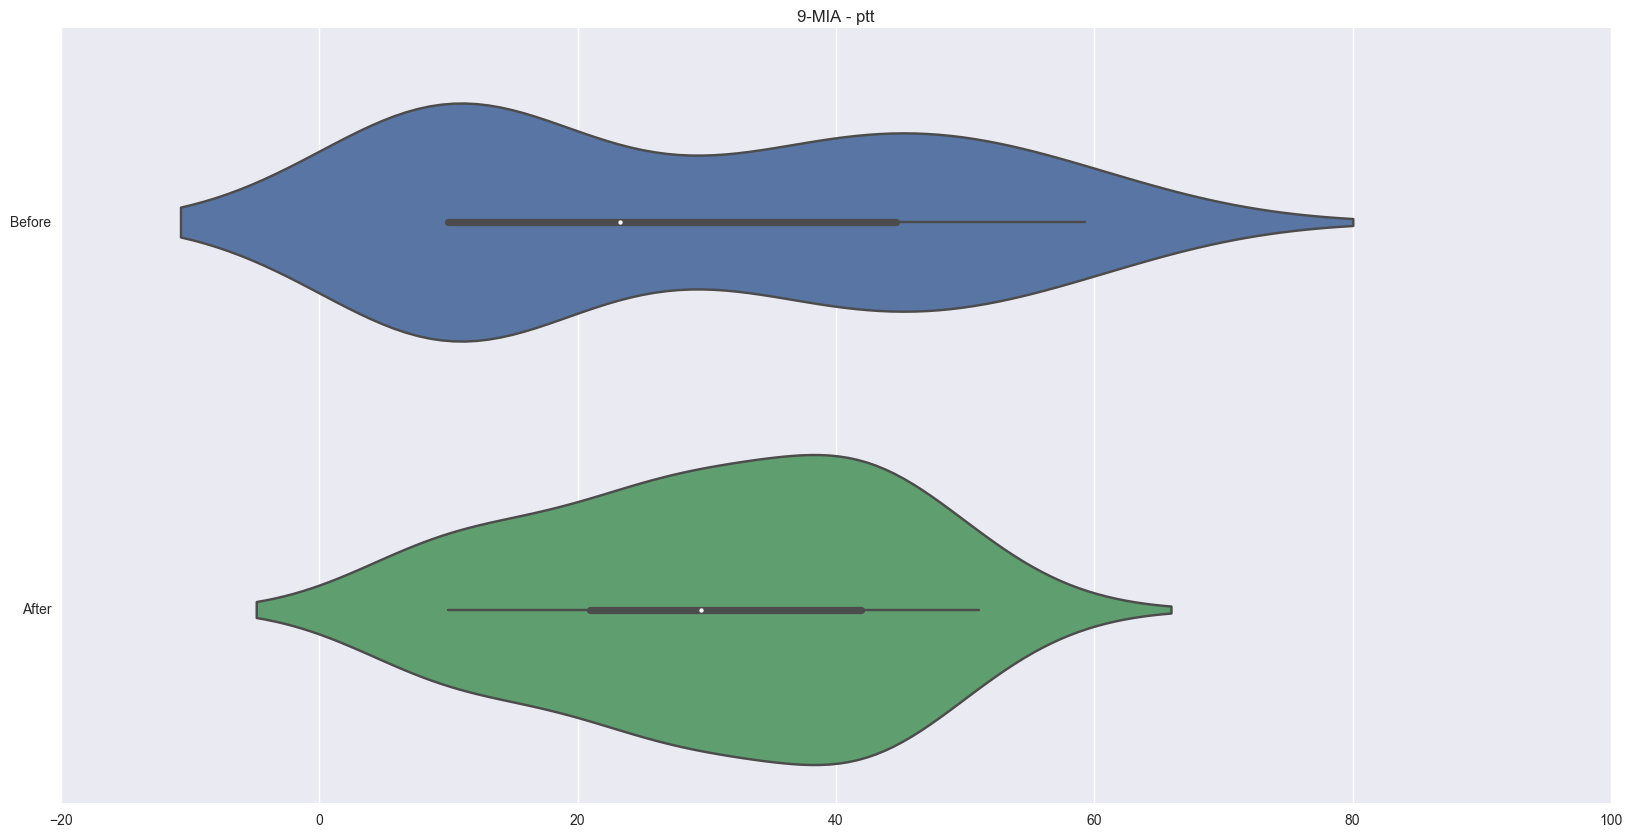

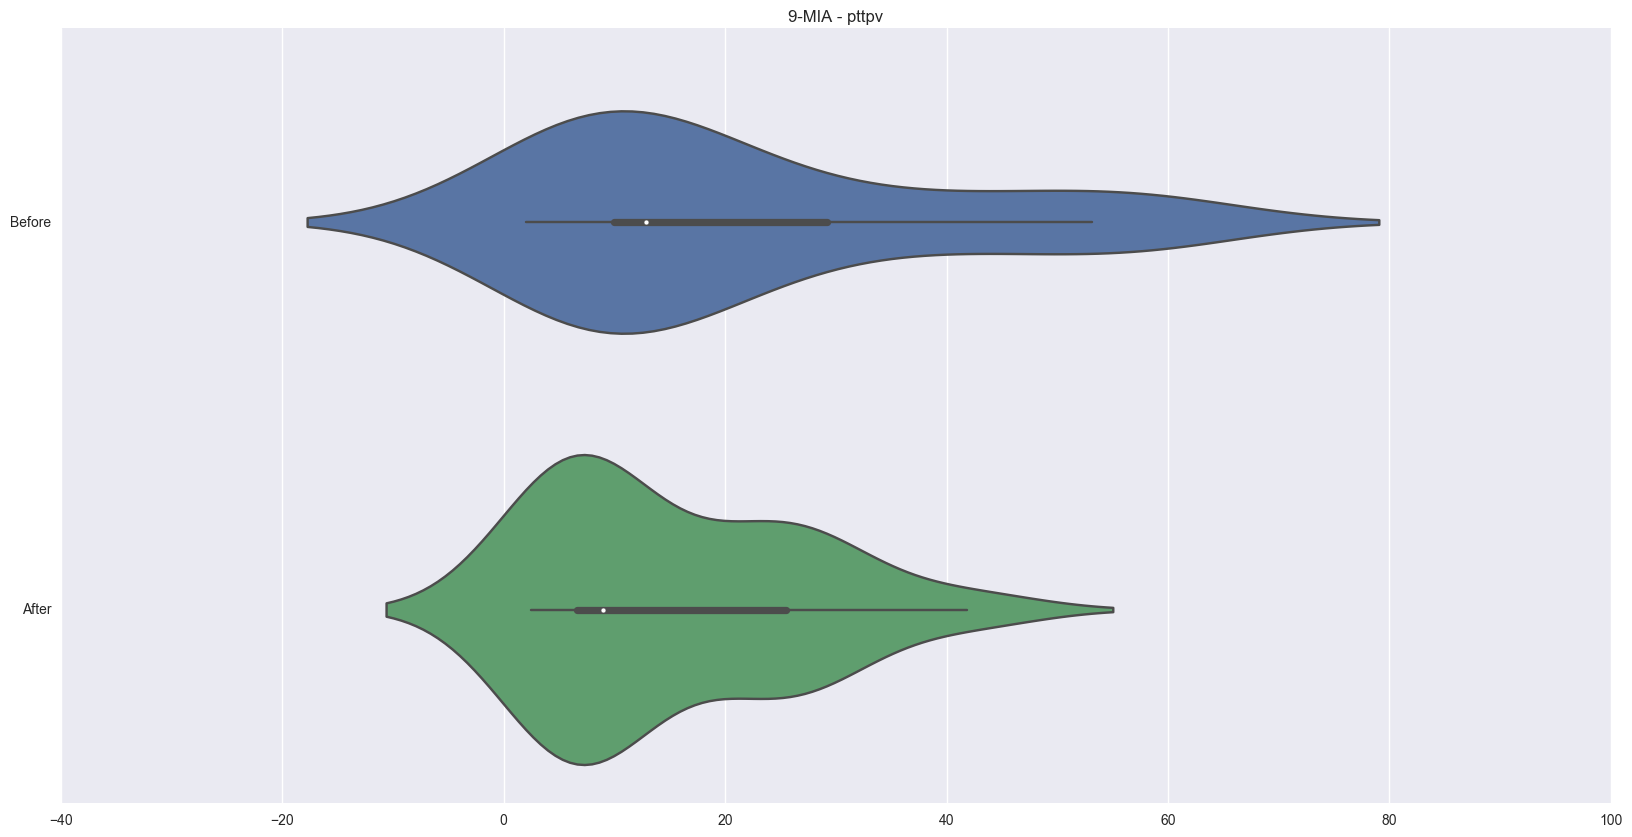

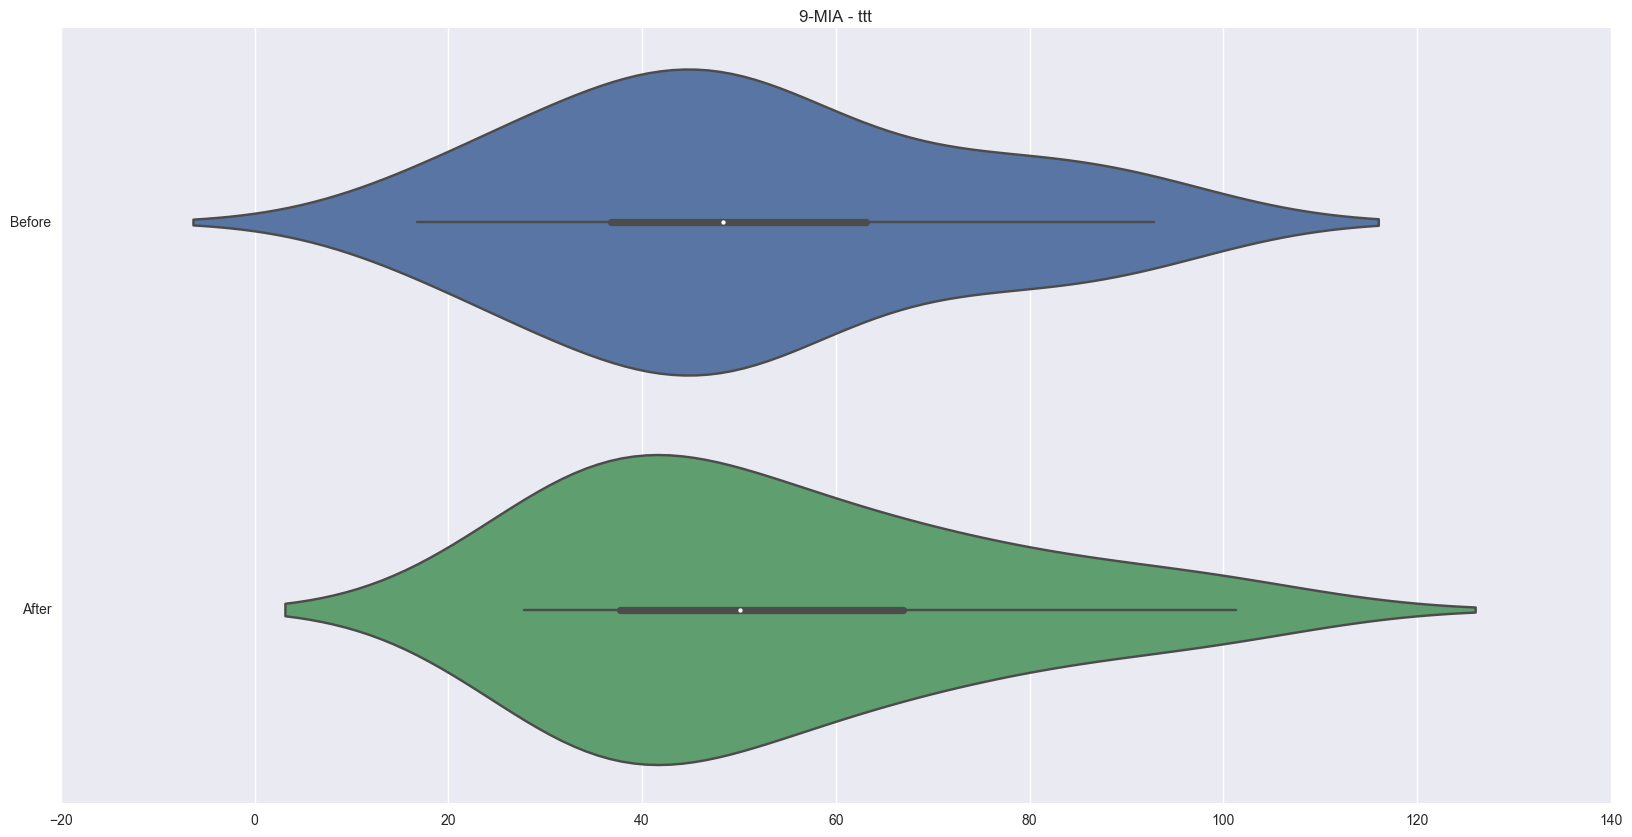

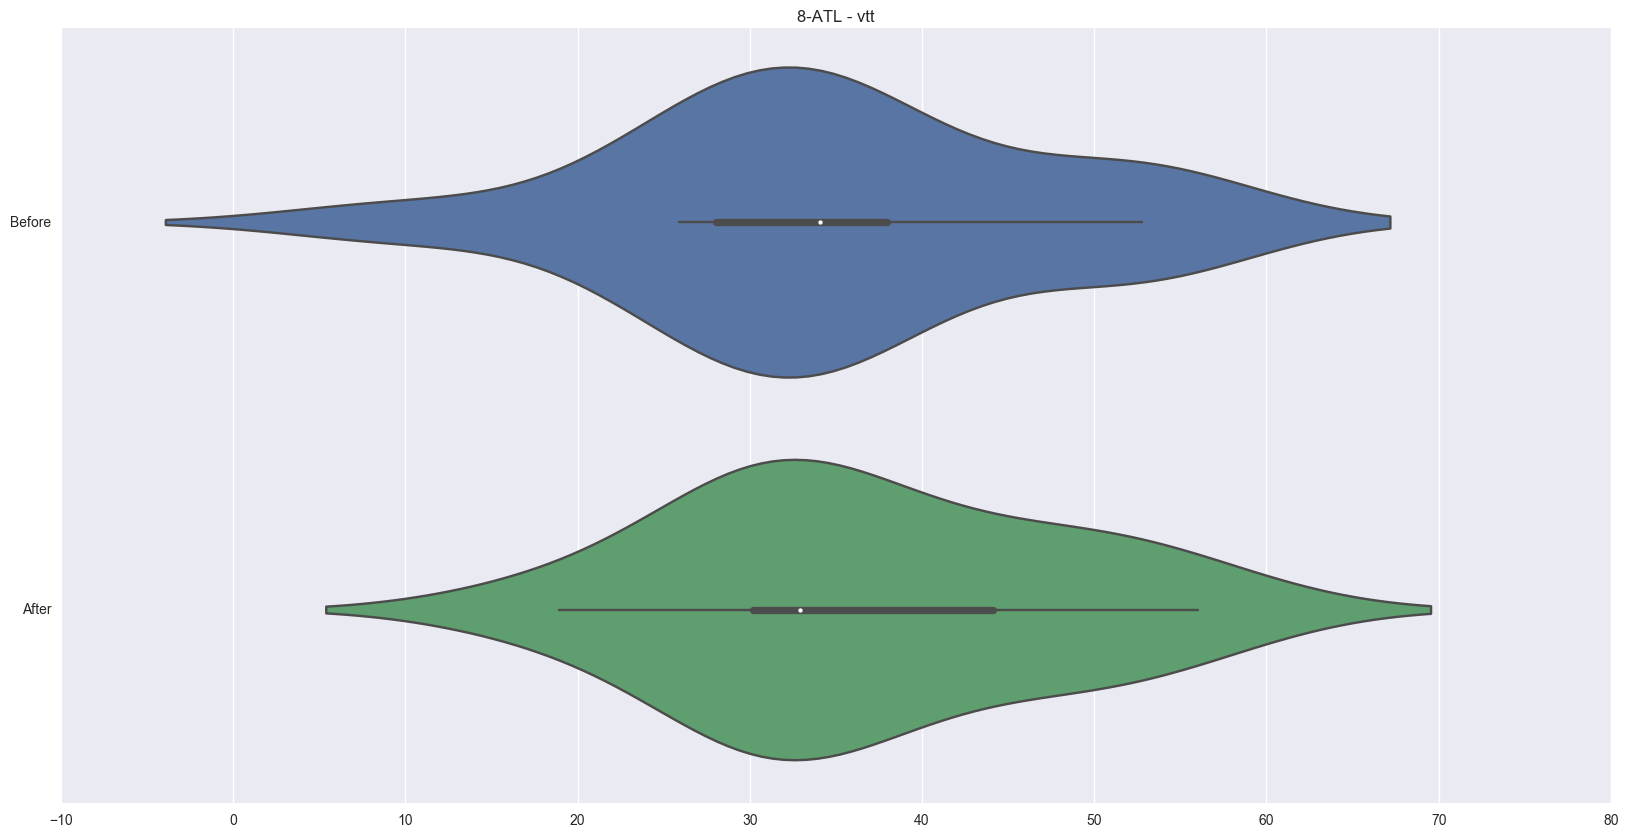

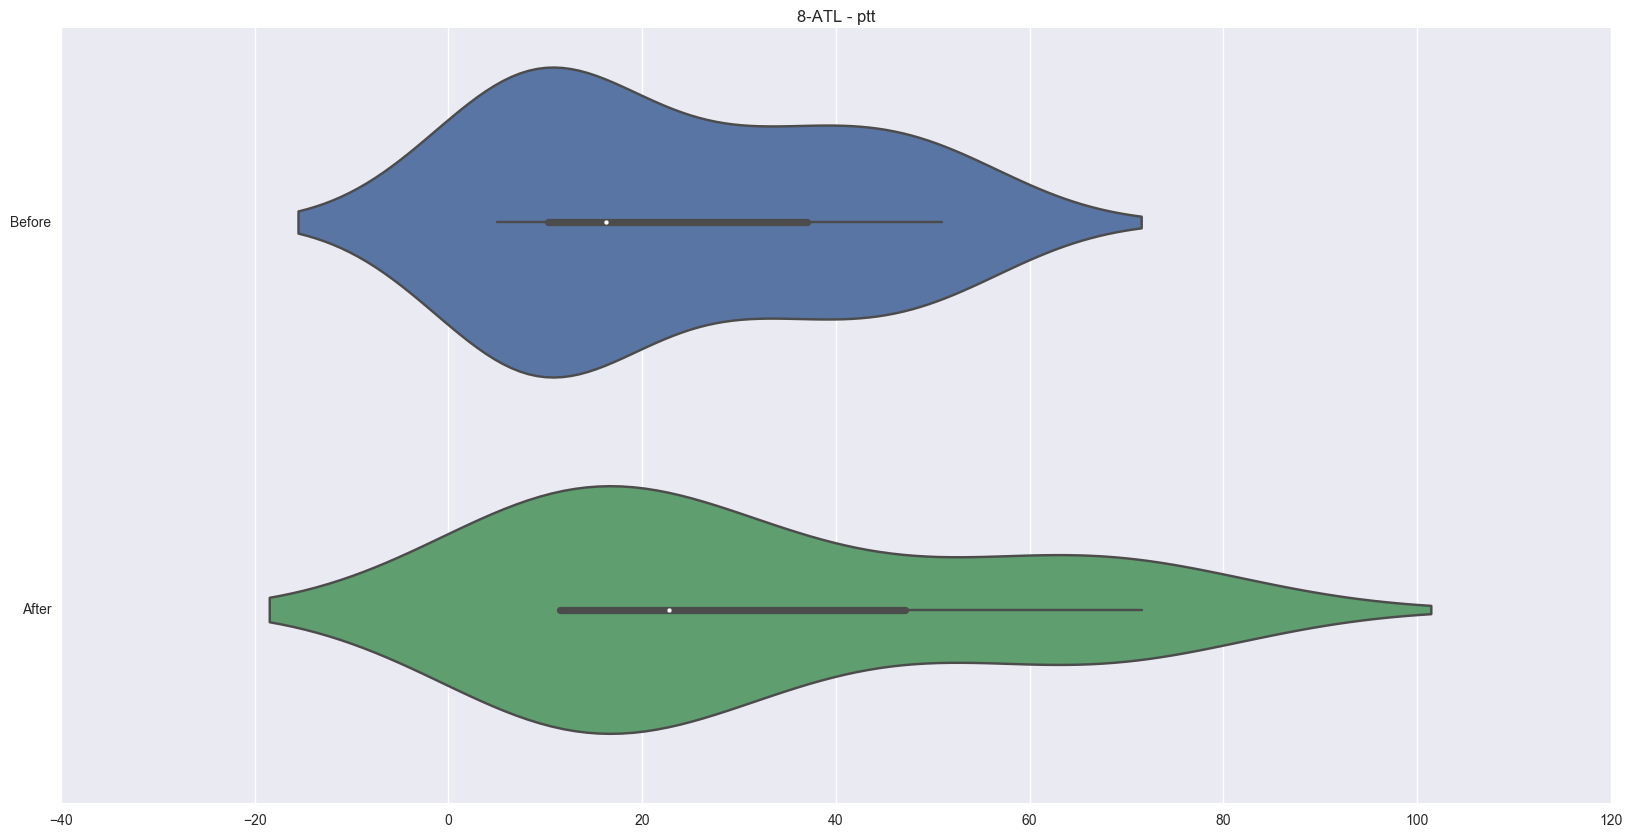

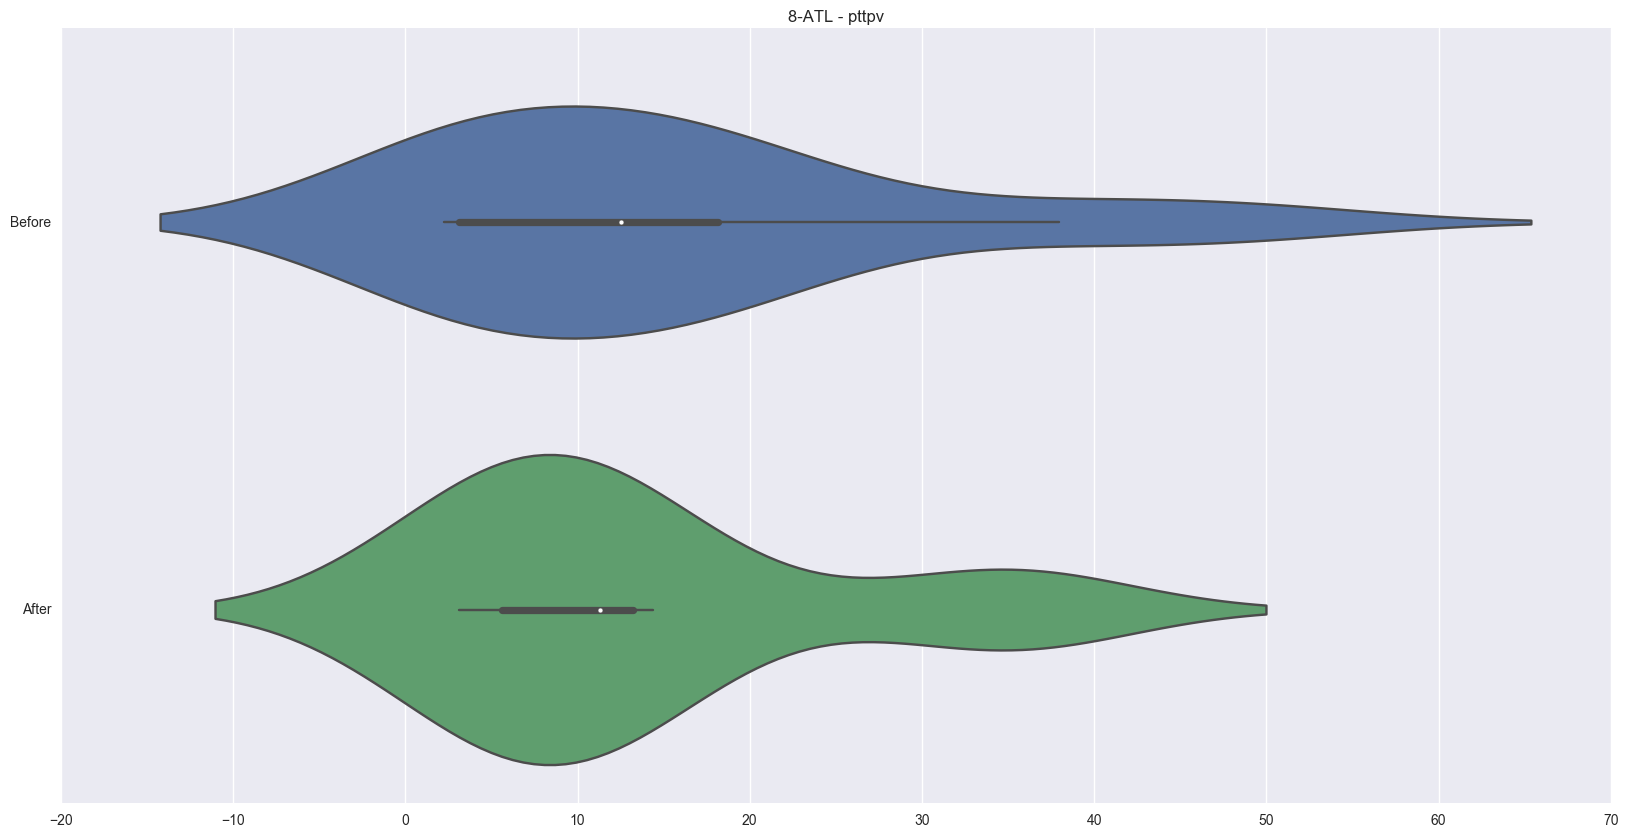

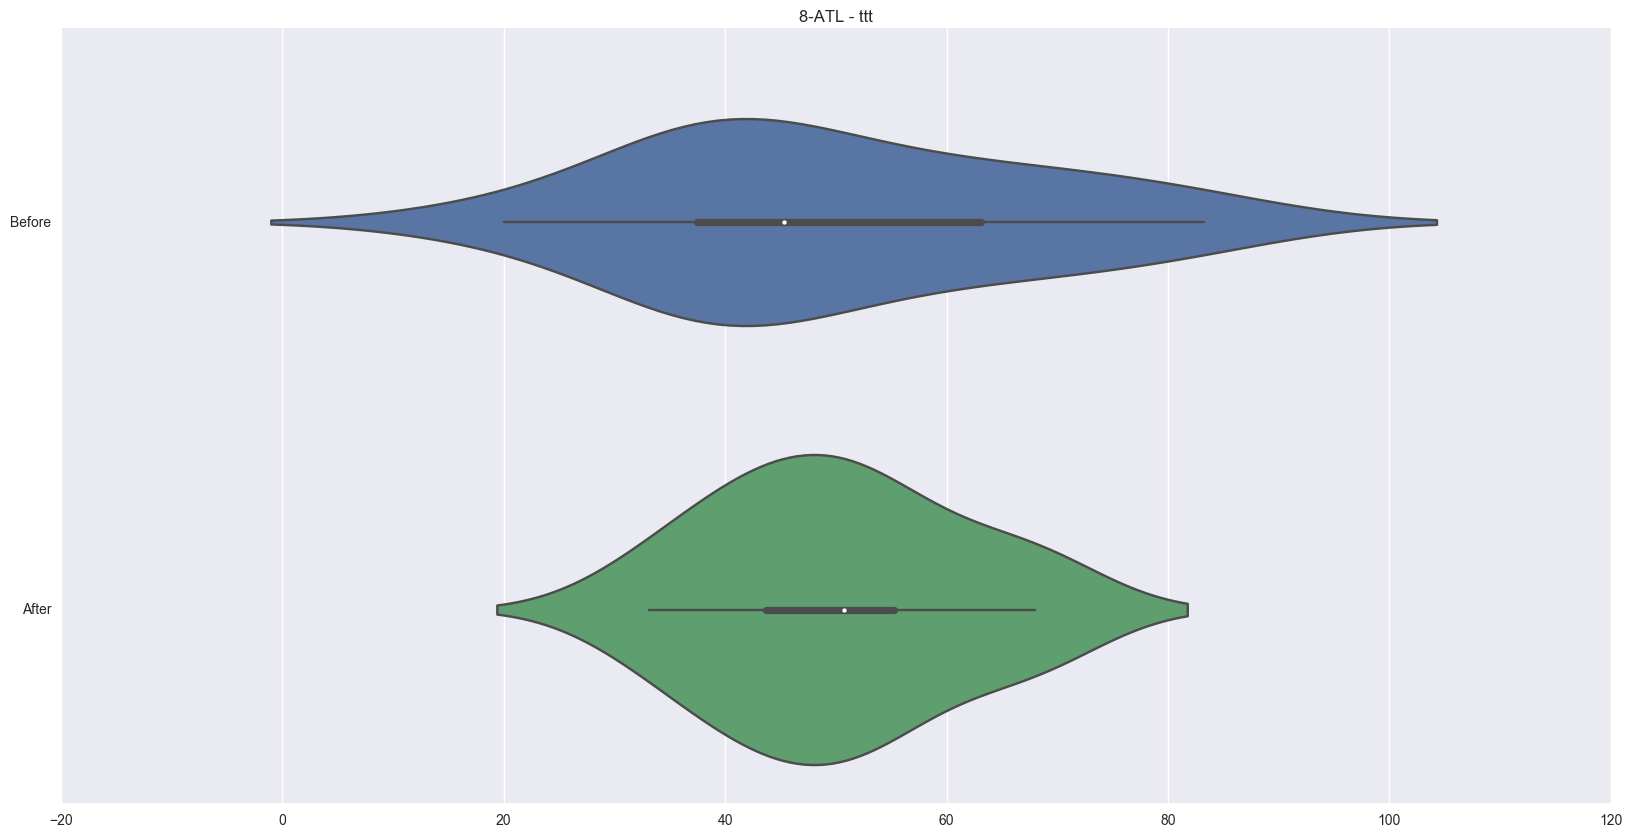

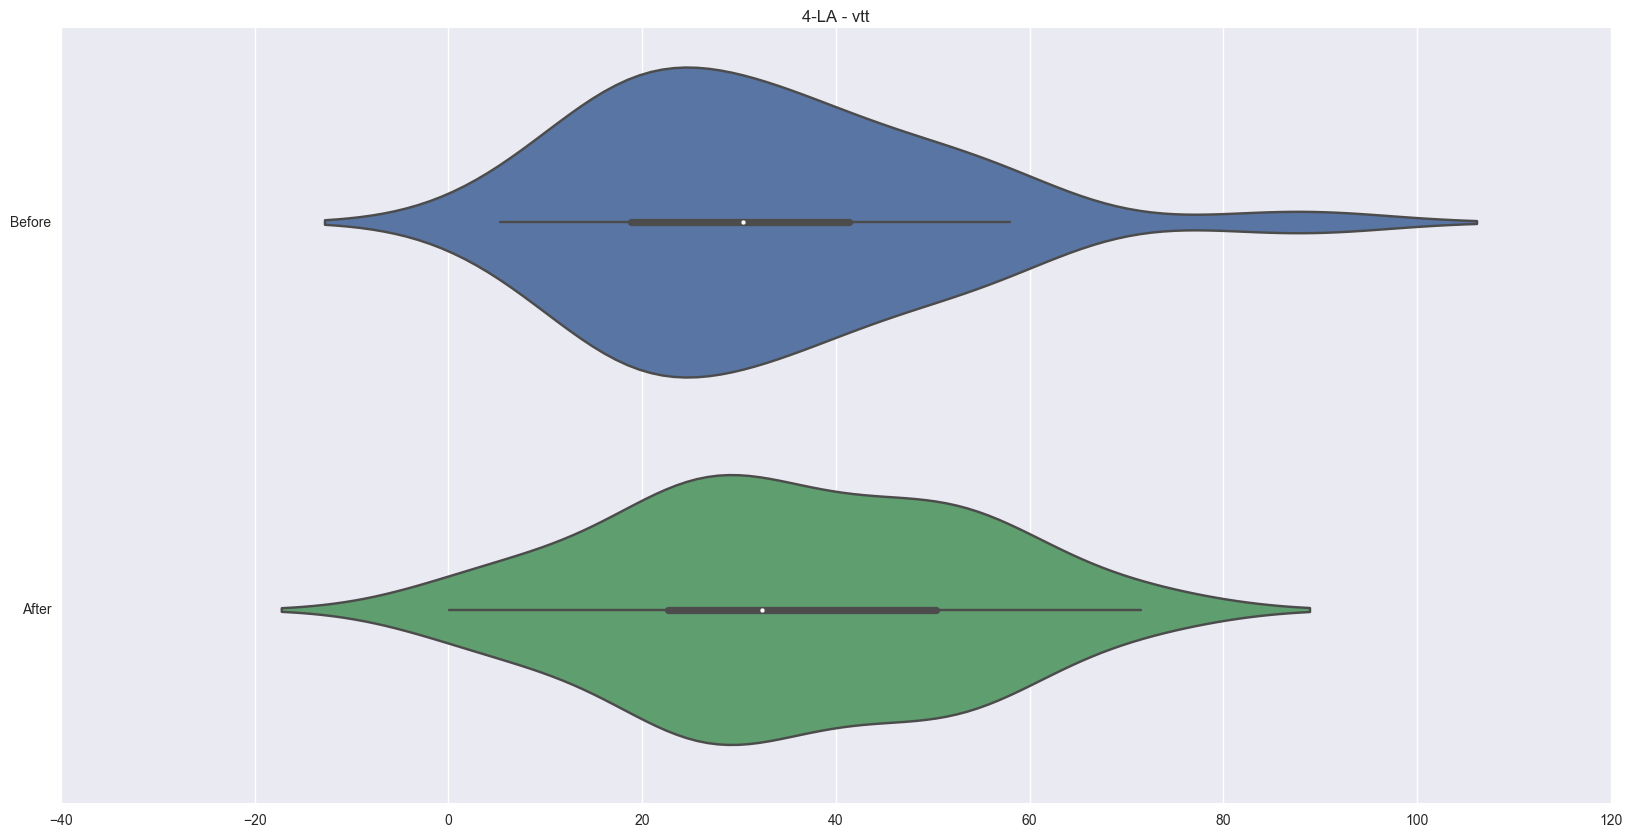

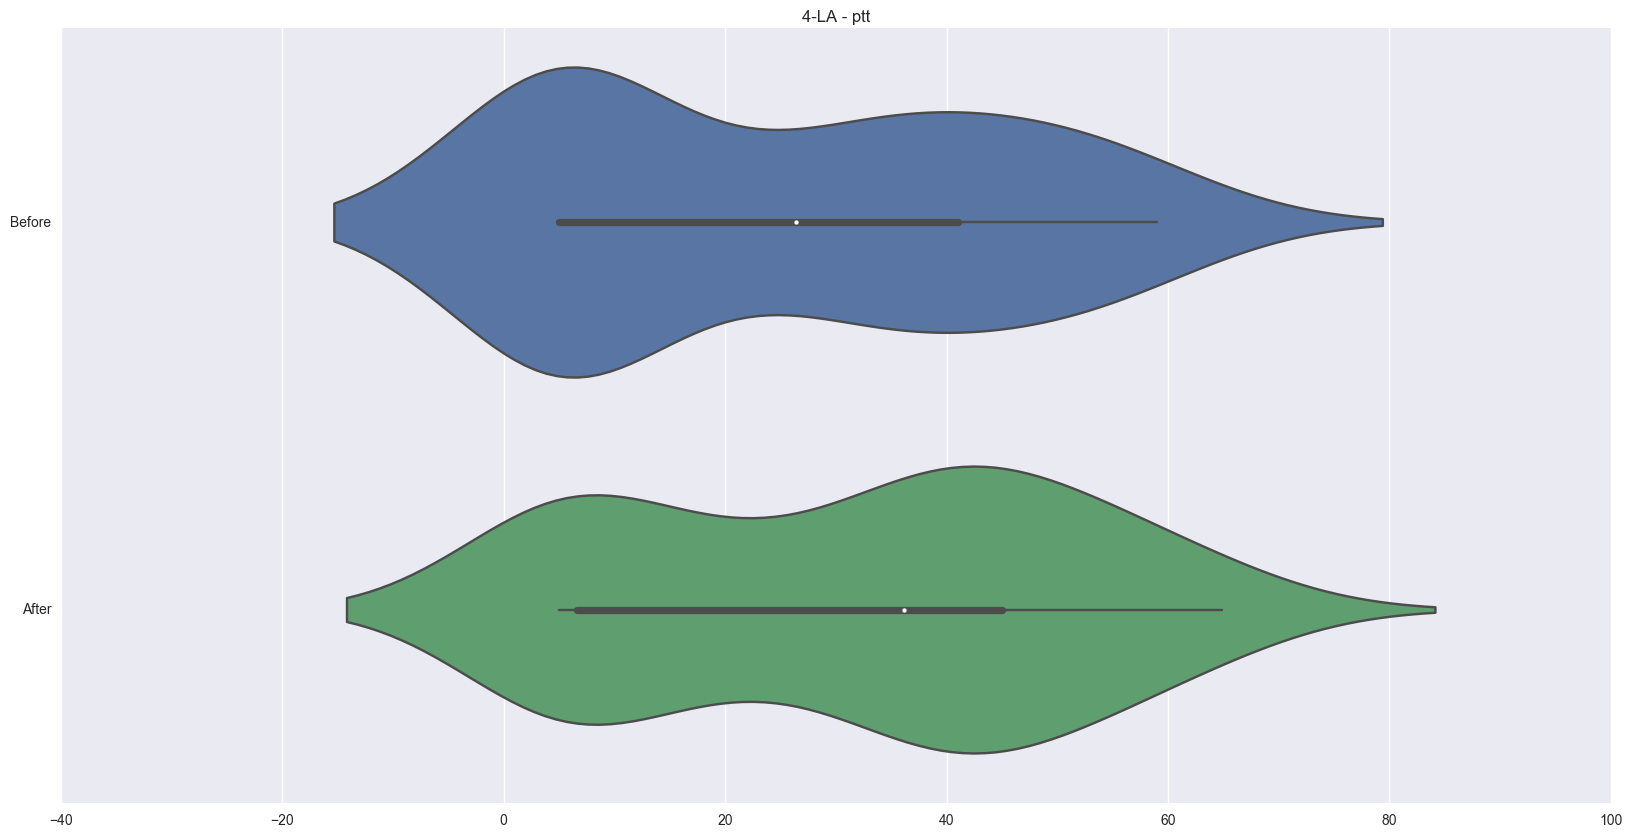

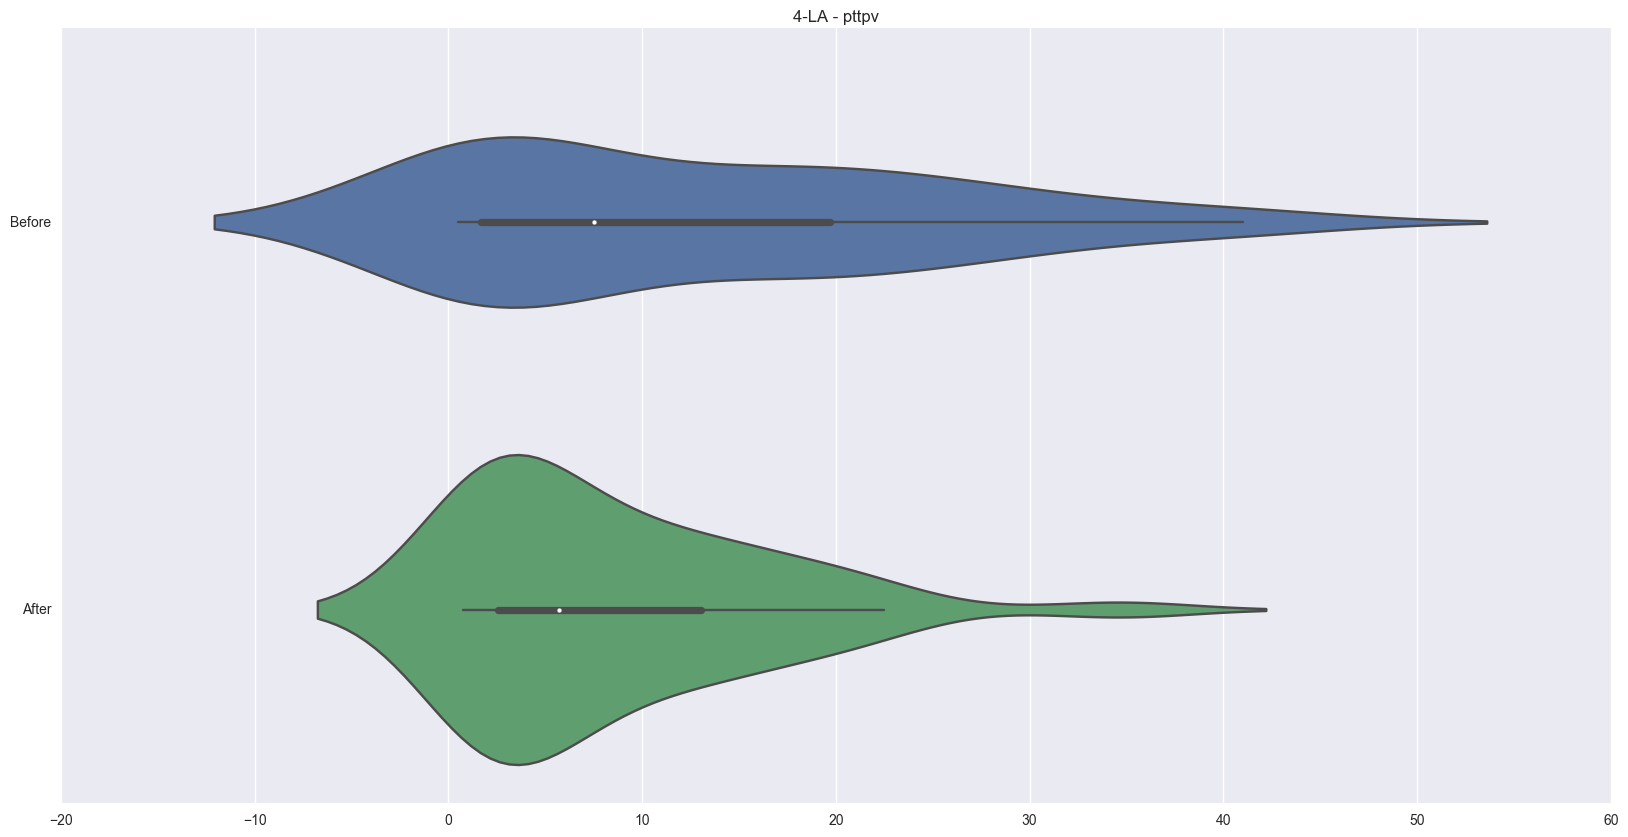

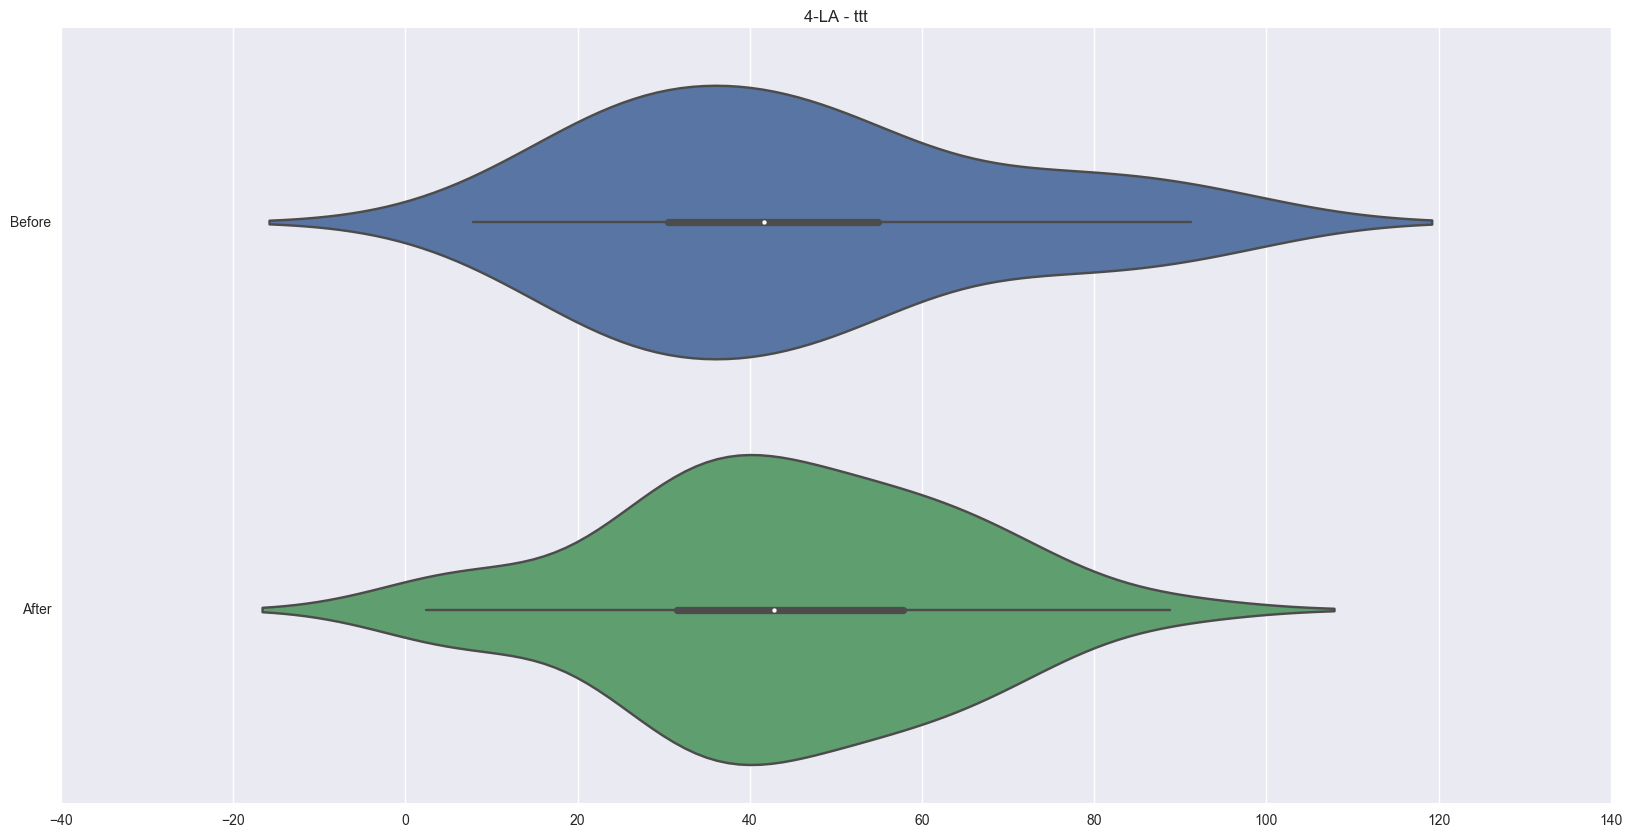

In [24]:
for market in location_dfs:
    for metric in ['vtt', 'ptt', 'pttpv', 'ttt']:
        data = [location_dfs[market]['before'][metric], location_dfs[market]['after'][metric]]
        plt.figure(figsize=(20,10))
        sns.violinplot(data=data, orient='h')
        plt.yticks([0, 1], ['Before', 'After'])
        plt.title(market+' - '+metric)
        plt.show()

#### Statistics

In [31]:
# market, metric, before_mu, after_mu, t, p_t, F, p_F, df
summary_table = []

for market in location_dfs:
    for metric in ['vtt', 'ptt', 'pttpv', 'ttt']:
        
        summary_row = [market, metric]
        
        before = location_dfs[market]['before'][metric]
        after = location_dfs[market]['after'][metric]
    
        # calculate summary stats

        before_mean = np.mean(before)
        after_mean = np.mean(after)
        
        before_std = np.std(before)
        after_std = np.std(after)
        
        mu_stats = ttest_ind(before, after, usevar='unequal')

        sigma_stats = levene(before, after)
        
        all_values = [before_mean, after_mean] + map(float, mu_stats) + [before_std, after_std] + map(float, sigma_stats)

        summary_row += all_values
    
        summary_table.append(summary_row)

In [32]:
sum_cols = ['market', 'metric', 'before_mean', 'after_mean', 
            't-score', 'p_t', 'df', 'before_std', 'after_std', 'F', 'p_F']
summary = pd.DataFrame(summary_table, columns=sum_cols)

summary.head()

,market,metric,before_mean,after_mean,t-score,p_t,df,before_std,after_std,F,p_F
0,2-NY,vtt,31.068690,24.658521,2.052420,0.044534,59.522023,12.266306,12.770762,0.000086,0.992620
1,2-NY,ptt,25.612143,18.880625,1.619444,0.111463,51.472512,17.683223,14.905374,1.622483,0.207213
2,2-NY,pttpv,15.405266,8.267936,2.177310,0.035461,39.703279,15.322605,8.941412,6.239542,0.014993
3,2-NY,ttt,46.473956,32.926457,3.266130,0.001859,56.275300,16.881320,16.104460,0.249480,0.619103
4,6-DAL,vtt,28.373088,41.511278,-4.269124,0.000353,20.622799,7.602342,10.395861,3.448069,0.069599


In [33]:
summary.to_csv('Pickup_Logic_Impact.csv', index=False)

In [28]:
# finally close the connection
conn.close()